**16 BUILDING PREDICTIVE MODELS - PART 1**

- Features have been engineered based on economic indicators, crime statistics, educational concerns and transport links.

- These features have been assembled into a single dataframe, with preliminary EDA.

- The next step is to perform predictive modelling.


In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm
import joblib
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score

In [7]:
# import dataframe of property transactions, set relevant dtypes to categorical ahead of dummifying, drop irrelevant column

latest_df = pd.read_csv('../../../big_files/latest_df.csv')
latest_df['zone_50m'] = latest_df['zone_50m'].astype('category')
latest_df['zone_200m'] = latest_df['zone_200m'].astype('category')
latest_df['zone_400m'] = latest_df['zone_400m'].astype('category')
latest_df['zone_800m'] = latest_df['zone_800m'].astype('category')
latest_df['zone_1600m'] = latest_df['zone_1600m'].astype('category')
latest_df['zone_2400m'] = latest_df['zone_2400m'].astype('category')
latest_df['good_school'] = latest_df['good_school'].astype('category')
latest_df['tube_zone'] = latest_df['tube_zone'].astype('category')
latest_df['any_tube'] = latest_df['any_tube'].astype('category')
latest_df = latest_df.drop(columns = ['Unnamed: 0'])

In [8]:
# list of features to be used for modelling

geographic_features = ['fsm_lsoa', 'ea_in_ward', 'avg_airbnb', 'airbnb_tot', 'crime_lsoa', 'deli_count', 'flor_count', 'rest_count', 'income_rank_pos','employment_rank_pos', 'education_rank_pos', 'health_dep_score', 'crime_rank_pos', 'housing_rank_pos', 'living_env_pos', 'zone_50m','zone_200m', 'zone_400m', 'zone_800m', 'zone_1600m', 'zone_2400m', 'dist_traf', 'gang_prob_pos', 'crime_worry_pos', 'safety_fears_pos', 'satisfaction_pos', 'gun_crime', 'knife_crime', 'good_school', 'tube_zone', 'any_tube']

In [11]:
# create a new dataframe containing only the features needed for modelling

geographic_df = latest_df[geographic_features]


# encode categorical columns

geographic_df = pd.get_dummies(geographic_df, drop_first=True)

# specify predictor matrix and target variable

X = geographic_df
y = latest_df['price']

# get train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# standardize the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [99]:
# create a linear regression model instance
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model.fit(X_train, y_train)
print("Training Score:", model.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model.score(X_test, y_test))

Cross-validated training scores: [0.20150111 0.20132547 0.20799617 0.2255638  0.21217959]
Mean cross-validated training score: 0.20971322957277758
Training Score: 0.21009111594393115
Test Score: 0.16841163829294492


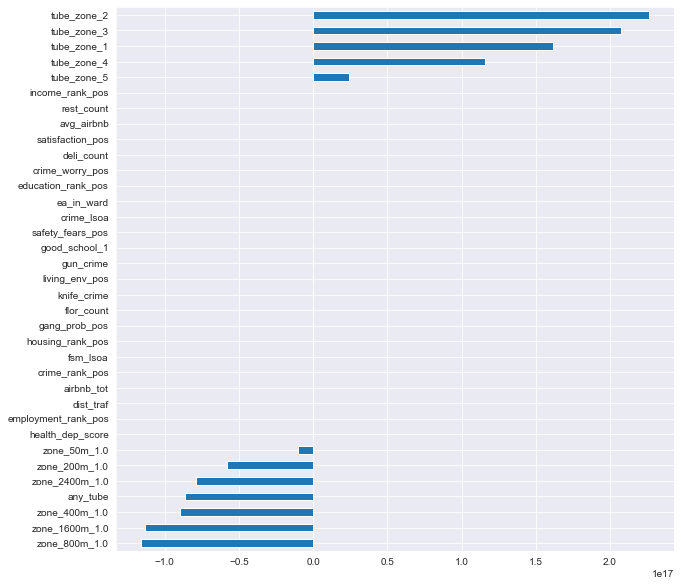

In [100]:
# check the LR coefficients - huge coefficients suggest that colinearity is a big problem


# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()

fig, ax = plt.subplots(figsize = (10,10))
df_coef.plot(kind = 'barh', ax = ax)
plt.show()

The issue with colinearity doesn't necessarily mean that a linear model can't work, it may be that regularisation with solve the problem. 

The next step is to try Ridge, Lasso and ElasticNet models.


In [102]:
# instantiate ridgeCV model, and grid search for best parameters

ridge_cv = RidgeCV(alphas= np.logspace(-4, 4, 10), cv=5)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

In [103]:
# check best score, it's hardly higher than the Linear Regression model

ridge_cv.best_score_

0.20971409869963878

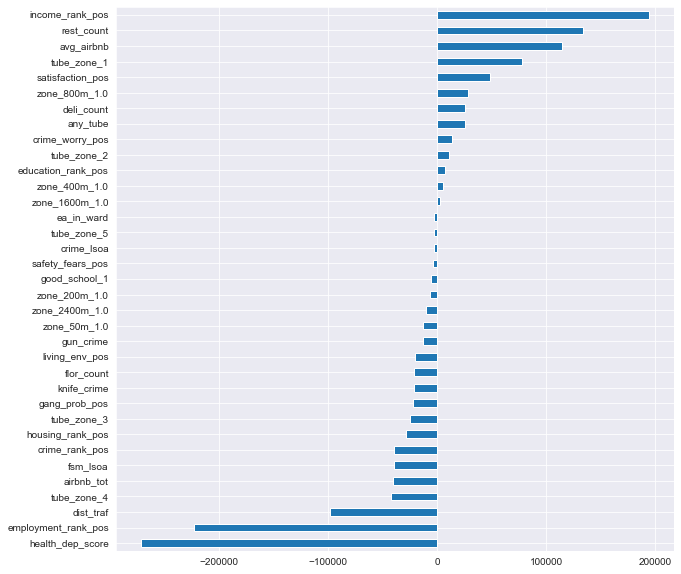

In [104]:
# check the ridge coefficients

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(ridge_cv.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

In [106]:
# instantiate lasso model, create param grid and grid search for best parameters

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5, n_jobs= -2, verbose = 2)
lasso_cv.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


(array([-4.92676194e+04, -0.00000000e+00,  1.26432652e+05, -2.20647680e+03,
       -9.05171522e+03,  2.97569722e+03, -3.21255410e+03,  1.31359755e+05,
        0.00000000e+00, -3.44190817e+04,  0.00000000e+00, -2.41190602e+05,
       -1.55859194e+04,  0.00000000e+00, -0.00000000e+00, -1.09916707e+05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.15486714e+04,
       -1.40377915e+03, -1.64980003e+04,  0.00000000e+00, -1.30427579e+03,
       -0.00000000e+00,  0.00000000e+00,  1.52550593e+04,  0.00000000e+00,
       -2.02042657e+02, -0.00000000e+00,  4.93034244e+04,  6.45939542e+03,
       -8.36908669e+03, -2.54138495e+04,  0.00000000e+00]), 2777308700384.0, 20745572661150.9, 23)
(array([ -39486.69367813,      -0.        ,  121904.5532552 ,
        -36125.22407066,   -9739.13199317,   21295.7427881 ,
        -19437.21070947,  143245.5044338 ,  166056.80866052,
       -190637.0410456 ,       0.        , -264106.79677161,
        -38355.53480142,  -19419.03813547,  -17174.0954

[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s


(array([ -49047.00678625,       0.        ,  120889.63689553,
         -2987.43300782,   -3594.56248067,    2276.81918293,
         -4252.89468071,  122008.14285941,       0.        ,
        -36949.10836487,       0.        , -243948.60285181,
        -14910.29598842,       0.        ,      -0.        ,
       -111284.06254119,       0.        ,       0.        ,
             0.        ,   43161.95906943,   -1083.39833336,
        -19391.69999941,       0.        ,   -2438.89604782,
            -0.        ,       0.        ,   16990.02066301,
             0.        ,    -531.04503817,      -0.        ,
         53543.31224977,    5424.40959476,   -7323.62682318,
        -26143.88160313,       0.        ]), 2673029089664.0, 20948566362878.5, 25)
(array([ -37270.19043081,      -0.        ,  116084.85185769,
        -38708.68983651,   -3515.81430164,   20353.57185429,
        -20731.40000615,  134267.73220101,  168281.99738961,
       -196580.69727801,    4768.90344136, -267418.51456611,

[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    1.3s finished


LassoCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5, n_jobs=-2, verbose=3)

In [107]:
# get the best alpha
print('Best alpha:', lasso_cv.alpha_)
# evaluate on the training set
print('Training score:', lasso_cv.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", lasso_cv.score(X_test, y_test))

Best alpha: 166.81005372000558
Training score: 0.21008731352883536
Test Score: 0.16842216959716017


In [108]:
lasso = Lasso(alpha = 21.54434690031882)
scores = cross_val_score(lasso, X_train, y_train, cv = 5)
print('cross val score:', scores.mean())

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2529903069066992.0, tolerance: 19778313970707.9
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2646276496350032.0, tolerance: 20745572661150.9
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585942666443520.0, tolerance: 20216253609954.562
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/line

cross val score: 0.20971450770102934


/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2670578528807168.0, tolerance: 20877036365247.457
  model = cd_fast.enet_coordinate_descent(


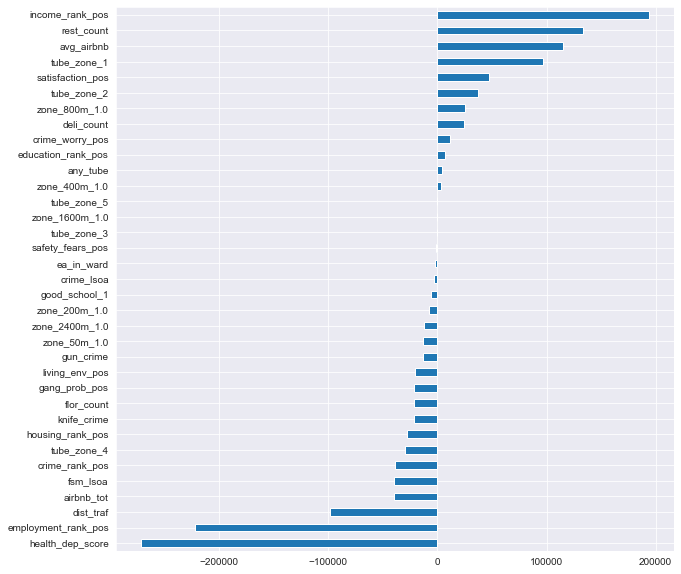

In [109]:
# check the lasso coefficients

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lasso_cv.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

In [110]:
# instantiate ElasticNetCV object, create param grid and search for best parameters

elasticnetcv = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter=1000000, n_jobs= -2, verbose = 3)
# fit the model
elasticnetcv.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', elasticnetcv.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', elasticnetcv.l1_ratio_)
# evaluate on the training set
print('Training score:', elasticnetcv.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", elasticnetcv.score(X_test, y_test))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


(array([-11.73423533,  17.15488662,  32.97801257,  20.59080007,
         9.44386964,  17.8001567 ,  11.61373352,  22.22724548,
        25.40420935,  20.71951648,  22.33073747, -30.11869985,
        12.13276165,  18.36488183,  10.52740877, -24.43844303,
        16.46583249,  20.00220068,  21.03960727,  24.30009769,
       -10.36213791,   1.3971293 ,  13.29379758,  -0.09939018,
         5.09570731,   9.97925761,   8.50527152,  -3.83783019,
        -4.16157649,   2.62091702,  24.62100631,   3.18344639,
        -7.82172811,  -4.25359488,  -0.79002144]), 1504.0, 19778313970707.9, 3)
(array([ -90.57005077,  132.19361892,  254.47145478,  158.68846314,
         72.73626852,  137.24147608,   89.44731392,  171.53164412,
        195.89001759,  159.67457588,  172.09930219, -232.47562899,
         93.48418032,  141.5390126 ,   81.0775155 , -188.46469151,
        127.00733658,  154.116795  ,  162.13108444,  187.29396627,
        -79.88967338,   10.75448981,  102.51231106,   -0.80624281,
         39.

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.489055232861168e+16, tolerance: 20745572661150.9
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.687204439104638e+16, tolerance: 19778313970707.9
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2307660106648288.0, tolerance: 20216253609954.562
  model = cd_fast.enet_coordinate_descent_gram(


(array([ -38960.6417281 ,   -3243.98618156,  120505.80964224,
        -41792.11761383,  -10084.1818646 ,   25758.40187029,
        -21441.00536206,  145548.91304306,  193343.33011499,
       -219456.40099983,    4774.65495221, -271182.49499441,
        -42035.09843101,  -27181.01157304,  -20795.36519918,
        -98645.90042104,  -21808.29705631,   14605.97497902,
         -4895.94423343,   46658.85392974,  -13471.99638431,
        -21190.22505973,   24372.75313608,  -12258.54338948,
         -6367.17787899,    5021.60976955,   27139.20552876,
          2706.88377068,  -10220.70946776,   -6627.54713849,
         76381.27871329,   11174.7271073 ,  -25301.45768617,
        -41901.89869025,   -2851.82893479]), 1.489055232861168e+16, 20745572661150.9, 1000000)
(array([ -41487.77686999,   -4279.88423238,  110716.30637565,
        -28411.82574016,   -5708.53468065,   26720.394791  ,
        -21465.00549727,  119997.59602746,  198547.9665765 ,
       -231416.11344082,    7432.44923623, -27305

(array([ -41478.43036769,   -4279.81701455,  110714.37729967,
        -28414.72376147,   -5706.94646725,   26720.67441185,
        -21465.4379268 ,  119996.70110815,  198600.83386178,
       -231468.97222642,    7435.13840248, -273067.23756336,
        -35759.81714211,  -28112.02038854,  -22132.1249918 ,
       -100767.65760857,  -23393.22867341,   14907.13823883,
         -7064.83894786,   50549.98598484,  -13800.74066556,
        -19029.52902701,   23403.83865096,  -13657.3636894 ,
         -5383.19887179,    5164.14489838,   27018.14718284,
          2259.44900654,  -11415.9262414 ,   -5892.39686873,
         73107.68134498,   11195.19871808,  -23822.24453183,
        -41708.93998895,   -2514.41522782]), 19771951755872.0, 19778313970707.9, 61984)
(array([-12.88864917,  19.61549114,  37.43858103,  23.03101084,
        10.80852004,  20.38827907,  13.15012197,  26.61242502,
        28.4343592 ,  23.23132326,  24.70195454, -33.58802034,
        13.07341352,  20.65696102,  12.03228169, -

(array([ -37200.95057767,   -3389.05531357,  110221.75584636,
        -40441.18924848,    4597.42101186,   24920.24493599,
        -21057.80806351,  129087.82434301,  199137.87501455,
       -228635.37191056,    9676.94287084, -269793.23815165,
        -38508.04914718,  -27306.13027278,  -19175.35156962,
        -96166.44069339,  -20137.91565602,   13444.97289515,
         -3122.53762385,   47751.02085008,  -13357.13299482,
        -22754.42085927,   26158.41468678,  -12598.24353193,
         -7473.48584287,    6422.03396737,   28317.31893178,
          2900.82662991,  -10552.26523251,   -5517.21403955,
         79640.17698776,   10793.39853306,  -24849.92278065,
        -43485.44307965,   -3129.38808095]), 20209336594048.0, 20216253609954.562, 61284)
(array([-12.87067628,  19.2411448 ,  36.96680317,  22.75172566,
        10.73301012,  19.92499208,  12.98133728,  25.7299755 ,
        28.22754438,  23.02232975,  24.76079373, -33.47903844,
        13.09057527,  20.47925167,  11.88530285,

(array([-4.32579928e+04, -1.10154823e+03,  1.17451654e+05, -4.73424075e+04,
       -1.16077768e+03,  2.45113707e+04, -2.12085712e+04,  1.39056339e+05,
        1.96250387e+05, -2.24210804e+05,  7.08219481e+03, -2.71686162e+05,
       -4.02489374e+04, -3.18874237e+04, -2.17190872e+04, -9.78970523e+04,
       -2.44061354e+04,  9.29056508e+03,  1.35722798e+02,  5.06894741e+04,
       -1.35951879e+04, -2.09823207e+04,  2.61825864e+04, -1.41403574e+04,
       -6.52592880e+03,  3.75154680e+03,  3.00549599e+04,  2.50783300e+03,
       -9.96125495e+03, -6.29798282e+03,  7.87959411e+04,  1.13310266e+04,
       -2.47161082e+04, -4.35216604e+04, -3.29494419e+03]), 20871968856576.0, 20877036365247.457, 60940)
(array([-22.45773436,  33.28658378,  64.92382849,  40.15445222,
        17.87376629,  34.57904054,  22.21008471,  43.43353117,
        49.77839747,  40.41117141,  43.63178722, -59.21026952,
        23.24858078,  35.70551966,  20.03904855, -47.84914787,
        31.91368638,  38.9766455 ,  41.05

(array([ -38914.95898873,   -3243.45472476,  120497.17891159,
        -41809.33319306,  -10076.12865169,   25759.19275551,
        -21443.14758879,  145547.84609627,  193597.67159335,
       -219710.2236406 ,    4787.74465153, -271237.46842478,
        -42041.4224179 ,  -27205.63162217,  -20795.16522097,
        -98646.59022166,  -21831.70180179,   14641.71931094,
         -4931.84900122,   46663.48016669,  -13475.33715019,
        -21186.39004958,   24377.31850312,  -12259.19962871,
         -6368.46383092,    5020.53076104,   27141.97743676,
          2708.10632107,  -10218.84163605,   -6627.18257822,
         76377.18995203,   11174.47794309,  -25295.69651038,
        -41896.95384791,   -2852.86105783]), 20745144832096.0, 20745572661150.9, 76608)
(array([ -36684.01866584,   -2516.45408327,  114579.12139875,
        -44591.23947899,   -3826.28784374,   24442.87563298,
        -22925.03685081,  136647.28677576,  195918.12408341,
       -226044.47542591,    9726.68659837, -274419.56060

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.468309708996424e+16, tolerance: 20948566362878.5
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.294917686945204e+16, tolerance: 20877036365247.457
  model = cd_fast.enet_coordinate_descent_gram(


(array([-22.22688859,  33.96871797,  65.21950581,  40.90303916,
        19.69413895,  35.3974871 ,  22.8521405 ,  44.97798471,
        49.72509182,  40.30837288,  43.62831106, -58.91921425,
        22.67630569,  35.85658571,  20.80318762, -48.16040259,
        32.08198165,  39.14507669,  41.19801403,  47.67030864,
       -19.79886326,   2.53058743,  25.85984643,  -0.        ,
         8.39747645,  19.65401362,  16.3051759 ,  -6.96064794,
        -7.19399507,   4.18915017,  48.99542571,   5.0317837 ,
       -14.62299532,  -7.46855629,  -0.6729975 ]), 1888.0, 20216253609954.562, 3)
(array([-1.77723874e+02,  2.67194221e+02,  5.08241769e+02,  3.20437878e+02,
        1.57621419e+02,  2.78457855e+02,  1.81759277e+02,  3.52689578e+02,
        3.88543293e+02,  3.15859936e+02,  3.41359024e+02, -4.60071157e+02,
        1.80525866e+02,  2.81759689e+02,  1.66058275e+02, -3.76590216e+02,
        2.53227859e+02,  3.06811605e+02,  3.22639638e+02,  3.72424202e+02,
       -1.58672756e+02,  2.60447156e+

(array([ -37162.58227365,   -3388.05383831,  110214.0706727 ,
        -40456.02721438,    4605.89900604,   24920.51936226,
        -21059.57426532,  129085.39483468,  199348.9065153 ,
       -228845.5319943 ,    9688.44331628, -269837.31047436,
        -38512.85422875,  -27326.13266286,  -19174.93854092,
        -96165.97766867,  -20156.50082076,   13473.82256539,
         -3150.73696483,   47754.04174659,  -13359.86947449,
        -22751.1017599 ,   26162.54459705,  -12598.34633909,
         -7474.50680909,    6421.1552529 ,   28319.6664306 ,
          2902.03781825,  -10550.76185561,   -5517.04717729,
         79637.56132081,   10793.18455212,  -24845.17483904,
        -43481.72811219,   -3130.18801009]), 20215561915072.0, 20216253609954.562, 77181)
(array([ -36636.63062945,   -2515.68437455,  114569.79719802,
        -44610.09123345,   -3816.61450744,   24443.53919463,
        -22927.57770175,  136645.40091137,  196177.76476222,
       -226304.17202426,    9741.36881421, -274475.618

(array([-36.62715714,  56.75967765, 110.19745795,  66.99126246,
        30.37198706,  59.08509274,  37.38524077,  77.75838603,
        83.19273235,  67.59129504,  71.9967674 , -98.66528381,
        37.15827802,  59.88149353,  34.03745924, -79.67772082,
        52.77089909,  64.67375502,  68.04935128,  78.78996689,
       -32.16233657,   4.2173557 ,  42.22308507,   0.        ,
        14.13510023,  31.47333574,  26.11085049, -10.88292155,
       -11.03963193,   5.62239792,  80.81533024,   7.79284174,
       -23.90747295, -11.69702747,  -0.29324037]), 14112.0, 20745572661150.9, 3)
(array([-296.2156423 ,  448.1162771 ,  859.33958688,  526.10411154,
        246.48315983,  466.68208509,  299.87333649,  611.351495  ,
        650.94029178,  530.76542778,  564.3422179 , -771.68810406,
        298.43088585,  472.1267886 ,  274.3944956 , -624.27103752,
        418.99753986,  508.14791358,  534.09895735,  616.35400405,
       -260.98046346,   47.57620829,  338.02917149,    0.        ,
        122

(array([ -41422.20658032,   -4279.40787534,  110702.77870651,
        -28432.12363583,   -5697.40653268,   26722.35750206,
        -21468.03344399,  119991.29722231,  198918.70130374,
       -231786.72253413,    7451.30682056, -273134.69329263,
        -35766.5773131 ,  -28141.74175835,  -22131.6583688 ,
       -100769.10787627,  -23422.1177645 ,   14952.00878699,
         -7111.08806265,   50556.97870936,  -13804.85938652,
        -19023.24772201,   23408.77626113,  -13657.83043622,
         -5384.91218936,    5162.37731379,   27021.06894443,
          2260.75183351,  -11413.76953113,   -5892.00447767,
         73101.27026835,   11194.8220215 ,  -23814.43280659,
        -41702.05404241,   -2515.43272391]), 19777021274080.0, 19778313970707.9, 107252)
(array([-36.57328053,  55.637749  , 108.78309473,  66.15474033,
        30.14594478,  57.69632586,  36.87968693,  75.11232421,
        82.57304316,  66.96502436,  72.17379657, -98.33898171,
        37.21000174,  59.34875346,  33.5974558 , 

(array([-37.53921884,  56.88987008, 109.90924712,  66.48340136,
        31.06769963,  58.73208593,  37.13642733,  76.27034409,
        83.58087876,  67.95762975,  72.41439251, -99.27383903,
        37.47996796,  59.34571361,  33.61549848, -79.55424904,
        52.72812487,  64.40668458,  67.87720305,  78.73570646,
       -32.17044371,   3.95070251,  42.68917487,  -0.        ,
        13.96345829,  30.70622713,  27.16773656, -10.82474907,
       -10.97690489,   5.6625188 ,  80.81941874,   7.76128868,
       -23.45759837, -11.659268  ,  -0.35264341]), 14208.0, 20877036365247.457, 3)
(array([-303.23364717,  449.12238358,  857.07814264,  522.20289332,
        251.86691301,  463.95859343,  297.98756488,  599.86476325,
        653.89511468,  533.54417991,  567.55048419, -776.33333411,
        300.92017348,  467.95885921,  271.1476865 , -623.29383406,
        418.66158715,  506.0712439 ,  532.75929917,  615.91851922,
       -261.03843689,   45.52631025,  341.5912047 ,   -0.87053735,
        1

(array([ -36617.6293946 ,   -2515.37451327,  114566.05992422,
        -44617.63604759,   -3812.74150015,   24443.80609722,
        -22928.59433415,  136644.63577309,  196281.82980749,
       -226408.23824245,    9747.25279641, -274498.05536185,
        -41243.1652776 ,  -29128.82200212,  -19783.78632202,
        -98366.02303912,  -21901.09922268,   17739.62110809,
         -7756.79208963,   48134.55886728,  -13083.64180041,
        -23945.42435221,   25330.86206777,  -11978.37928796,
         -8096.49779063,    6371.32184505,   28672.86554067,
          2246.27143989,  -10817.58141923,   -5221.09752432,
         80457.25899126,    9507.95280805,  -25069.12771008,
        -43149.58837279,   -2886.03441132]), 20947000248544.0, 20948566362878.5, 107116)
(array([ -41466.66836689,   -4279.7297482 ,  110711.950856  ,
        -28418.36553651,   -5704.94828235,   26721.02392642,
        -21465.9804853 ,  119995.57188551,  198667.34154252,
       -231535.46360789,    7438.51905003, -273081.3645

(array([-106.7221666 ,  164.91597923,  320.83107771,  199.42678593,
         93.89252488,  172.13468956,  109.56459295,  220.05395424,
        243.45162038,  196.45103325,  212.97729327, -289.54499552,
        108.72420328,  174.32991282,   99.38272445, -235.70062762,
        155.70803029,  190.62826289,  200.8674135 ,  233.10948934,
        -94.49583467,    8.55570018,  124.68814847,   -0.        ,
         37.70125885,   93.74903025,   77.20165081,  -30.58058355,
        -31.82618257,   16.79395789,  239.93524629,   20.96068153,
        -68.74592528,  -33.19513891,   -0.        ]), 1085120.0, 20216253609954.562, 3)
(array([-8.60179618e+02,  1.27634797e+03,  2.46148344e+03,  1.53288112e+03,
        7.49202795e+02,  1.33702872e+03,  8.63065863e+02,  1.70927114e+03,
        1.86882576e+03,  1.51036994e+03,  1.63344070e+03, -2.23379478e+03,
        8.59537583e+02,  1.34799596e+03,  7.88167196e+02, -1.81285050e+03,
        1.22031834e+03,  1.46448971e+03,  1.54215856e+03,  1.78390766e+03,

(array([ -36662.64546775,   -2516.1051287 ,  114574.91611967,
        -44599.74543977,   -3821.92190677,   24443.17211513,
        -22926.1825568 ,  136646.43855726,  196035.23555812,
       -226161.62034704,    9733.3070979 , -274444.85940273,
        -41237.21640643,  -29105.17124218,  -19784.29716229,
        -98366.17299693,  -21878.51409246,   17703.09369448,
         -7720.12369329,   48130.0722659 ,  -13080.58019063,
        -23949.0206922 ,   25325.79378221,  -11978.44068584,
         -8095.94845795,    6371.06725867,   28668.85596714,
          2243.70492684,  -10820.16553721,   -5221.42410093,
         80461.40755702,    9510.02172713,  -25072.79572151,
        -43153.22563414,   -2884.94644339]), 20946976833792.0, 20948566362878.5, 38919)
(array([-110.26521998,  167.89258113,  326.66562517,  196.54294929,
         90.72345841,  173.48366272,  108.83100798,  226.10878343,
        247.74912991,  200.94726519,  214.26379001, -294.92961965,
        109.88497496,  175.2348721 ,  

(array([ -41430.3867343 ,   -4279.46555763,  110704.46640034,
        -28429.59263436,   -5698.79258333,   26722.11007395,
        -21467.65518843,  119992.08399148,  198872.45830463,
       -231740.50244809,    7448.95236008, -273124.88964562,
        -35765.59365862,  -28137.41849108,  -22131.72566134,
       -100768.90059801,  -23417.91637877,   14945.47294176,
         -7104.34977927,   50555.95928148,  -13804.25945087,
        -19024.16172168,   23407.47665764,  -13658.02647911,
         -5386.1621063 ,    5160.31814277,   27017.66350114,
          2257.65263996,  -11416.11531078,   -5892.06079899,
         73104.9847608 ,   11198.76954144,  -23811.99087746,
        -41701.06357269,   -2514.86730039]), 19776236569184.0, 19778313970707.9, 59707)
(array([ -36598.60200931,   -2515.06352203,  114562.31833883,
        -44625.18312864,   -3808.86643541,   24444.07384315,
        -22929.61112242,  136643.86446138,  196386.01326605,
       -226512.41072583,    9753.14306836, -274520.49927

(array([ -38904.62494206,   -3243.33142523,  120495.22786744,
        -41813.21810127,  -10074.30872227,   25759.369609  ,
        -21443.62999153,  145547.598359  ,  193655.17216521,
       -219767.59550209,    4790.70155586, -271249.88074733,
        -42042.84825627,  -27211.19201881,  -20795.11706412,
        -98646.74287763,  -21836.98236479,   14649.79590911,
         -4939.95527748,   46664.51495076,  -13476.09240224,
        -21185.52032321,   24377.75507967,  -12259.62437091,
         -6370.32802524,    5017.85552615,   27139.47462351,
          2705.32783082,  -10220.55258294,   -6627.09858766,
         76379.17182674,   11178.49056598,  -25290.65299601,
        -41893.75156368,   -2852.65797299]), 20745018231872.0, 20745572661150.9, 59163)
(array([ -37151.73761522,   -3387.76819852,  110211.89982898,
        -40460.2098297 ,    4608.2891036 ,   24920.59545958,
        -21060.07152504,  129084.70342677,  199408.52481546,
       -228904.89428728,    9691.68968176, -269849.74773

[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   15.9s


(array([-212.71431472,  325.01607141,  642.4790578 ,  387.46222669,
        173.51526711,  337.67977468,  213.41810811,  442.22136518,
        485.56292303,  392.2541985 ,  423.21327112, -580.6666388 ,
        215.51433783,  347.13425643,  193.98595906, -467.45050789,
        307.74126879,  377.93940418,  397.53518211,  461.81617156,
       -186.6057694 ,    9.73855973,  245.33713314,   -0.        ,
         75.35047685,  182.86860215,  152.23654619,  -60.51272193,
        -61.11652826,   30.94305691,  476.6765342 ,   39.47903577,
       -136.29488582,  -65.14001295,   -0.        ]), 16669440.0, 20948566362878.5, 3)
(array([-1671.5006208 ,  2413.59089455,  4786.838805  ,  2857.17144399,
        1327.34296869,  2529.85169613,  1607.30313854,  3342.24658433,
        3594.28997443,  2892.37490587,  3114.31255171, -4361.01179876,
        1631.78948208,  2577.61002762,  1471.94484648, -3473.03397691,
        2335.66017188,  2781.60999236,  2927.15737082,  3394.93436762,
       -1448.4399176

(array([-4.32118256e+04, -1.10030544e+03,  1.17442500e+05, -4.73621954e+04,
       -1.15027021e+03,  2.45117431e+04, -2.12107162e+04,  1.39054391e+05,
        1.96514575e+05, -2.24474304e+05,  7.09581367e+03, -2.71742487e+05,
       -4.02552993e+04, -3.19140925e+04, -2.17189972e+04, -9.78970073e+04,
       -2.44308967e+04,  9.32416984e+03,  1.02345024e+02,  5.06950301e+04,
       -1.35987379e+04, -2.09780996e+04,  2.61873416e+04, -1.41412148e+04,
       -6.52863093e+03,  3.74806935e+03,  3.00547807e+04,  2.50623877e+03,
       -9.96137908e+03, -6.29756810e+03,  7.87957728e+04,  1.13351805e+04,
       -2.47066894e+04, -4.35151117e+04, -3.29565020e+03]), 20876753681792.0, 20877036365247.457, 59327)
(array([-1025.01638048,  1509.88802264,  3051.32447729,  1835.38432083,
         781.09053422,  1583.34201999,   982.41374058,  2027.77458717,
        2303.4456551 ,  1844.65816732,  1997.53408396, -2788.59402528,
        1036.17765804,  1626.03607044,   881.25831706, -2217.81739052,
        1

(array([ -38924.06598004,   -3243.54048785,  120498.90646305,
        -41805.87979529,  -10077.72843017,   25759.01351041,
        -21442.71047134,  145548.04775187,  193546.87457516,
       -219659.525828  ,    4785.10996354, -271226.49452831,
        -42040.14780394,  -27200.70099698,  -20795.19267752,
        -98646.46277052,  -21827.00111887,   14634.52154933,
         -4924.58703275,   46662.50775479,  -13474.66566648,
        -21187.15056046,   24373.39076081,  -12260.61737433,
         -6377.02208246,    5007.12099082,   27123.89115386,
          2690.74682103,  -10231.16405179,   -6627.24607796,
         76394.01772817,   11196.94510913,  -25276.23199217,
        -41886.46487897,   -2850.24877746]), 20744865136576.0, 20745572661150.9, 27600)
(array([ -41401.28971882,   -4279.25122193,  110698.46699956,
        -28438.57946417,   -5693.86303025,   26722.98167155,
        -21468.99530211,  119989.27624345,  199036.87733834,
       -231904.82505388,    7457.31539435, -273159.72956

(array([-1020.25186928,  1534.88519331,  3090.04186349,  1832.31695902,
         810.22398746,  1605.21258169,   998.46091436,  2128.81999234,
        2313.29807932,  1854.47119893,  2002.72231819, -2800.13552401,
        1011.34344842,  1642.1002558 ,   907.26110545, -2231.01519654,
        1468.73097087,  1783.5902233 ,  1879.14367962,  2189.37830456,
        -882.31566589,    36.53446302,  1165.88470405,    -0.        ,
         345.57107174,   861.99676681,   727.37640679,  -277.78517668,
        -288.47313629,   137.09363622,  2282.16114709,   175.18194251,
        -642.95817086,  -308.21292763,    -0.        ]), 334013280.0, 20948566362878.5, 4)
(array([ -6667.40831187,   8489.93446878,  18951.96087137,  10097.4450574 ,
         4412.50337646,   9334.07890141,   5370.8987513 ,  13398.90814828,
        13362.696423  ,  10184.17053505,  11046.08686361, -17609.85230931,
         5569.83247691,   9188.85032263,   4942.08465961, -13137.22662972,
         8892.80898229,   9735.88611999

(array([ -36596.4533153 ,   -2515.02601759,  114561.89668901,
        -44626.03196325,   -3808.42854819,   24444.10167451,
        -22929.72462476,  136643.77543373,  196397.76461705,
       -226524.15891925,    9753.8051746 , -274523.02928133,
        -41245.95468528,  -29139.92992454,  -19783.54091408,
        -98365.94465296,  -21911.6959991 ,   17756.7890754 ,
         -7774.01446118,   48136.64753475,  -13085.08163371,
        -23943.72795014,   25330.63932665,  -11979.9643176 ,
         -8105.9212871 ,    6357.28719657,   28656.53273277,
          2229.69278995,  -10828.7912301 ,   -5220.94133069,
         80471.52831457,    9529.6718739 ,  -25046.55186011,
        -43136.25914705,   -2884.11574261]), 20948411679840.0, 20948566362878.5, 84491)
(array([-4.31838652e+04, -1.09955199e+03,  1.17436958e+05, -4.73741536e+04,
       -1.14391840e+03,  2.45119721e+04, -2.12120123e+04,  1.39053196e+05,
        1.96674492e+05, -2.24633766e+05,  7.10405808e+03, -2.71776525e+05,
       -4.0259

(array([-4.92676194e+04, -0.00000000e+00,  1.26432652e+05, -2.20647680e+03,
       -9.05171522e+03,  2.97569722e+03, -3.21255410e+03,  1.31359755e+05,
        0.00000000e+00, -3.44190817e+04,  0.00000000e+00, -2.41190602e+05,
       -1.55859194e+04,  0.00000000e+00, -0.00000000e+00, -1.09916707e+05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.15486714e+04,
       -1.40377915e+03, -1.64980003e+04,  0.00000000e+00, -1.30427579e+03,
       -0.00000000e+00,  0.00000000e+00,  1.52550593e+04,  0.00000000e+00,
       -2.02042657e+02, -0.00000000e+00,  4.93034244e+04,  6.45939542e+03,
       -8.36908669e+03, -2.54138495e+04,  0.00000000e+00]), 2777308700384.0, 20745572661150.9, 23)
(array([ -39486.69367813,      -0.        ,  121904.5532552 ,
        -36125.22407066,   -9739.13199317,   21295.7427881 ,
        -19437.21070947,  143245.5044338 ,  166056.80866052,
       -190637.0410456 ,       0.        , -264106.79677161,
        -38355.53480142,  -19419.03813547,  -17174.0954

(array([ -49047.00678625,       0.        ,  120889.63689553,
         -2987.43300782,   -3594.56248067,    2276.81918293,
         -4252.89468071,  122008.14285941,       0.        ,
        -36949.10836487,       0.        , -243948.60285181,
        -14910.29598842,       0.        ,      -0.        ,
       -111284.06254119,       0.        ,       0.        ,
             0.        ,   43161.95906943,   -1083.39833336,
        -19391.69999941,       0.        ,   -2438.89604782,
            -0.        ,       0.        ,   16990.02066301,
             0.        ,    -531.04503817,      -0.        ,
         53543.31224977,    5424.40959476,   -7323.62682318,
        -26143.88160313,       0.        ]), 2673029089664.0, 20948566362878.5, 25)
(array([ -37270.19043081,      -0.        ,  116084.85185769,
        -38708.68983651,   -3515.81430164,   20353.57185429,
        -20731.40000615,  134267.73220101,  168281.99738961,
       -196580.69727801,    4768.90344136, -267418.51456611,

[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   20.7s finished


Best alpha: 166.81005372000558
Best l1-ratio: 1.0
Training score: 0.21008731352883536
Test Score: 0.16842216959716017


In [111]:
# create an ElasticNet model instance
elasticnet = ElasticNet(alpha = elasticnetcv.alpha_, l1_ratio = elasticnetcv.l1_ratio_)

# get cross validated scores
scores = cross_val_score(elasticnet, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
elasticnet.fit(X_train, y_train)
print("Training Score:", elasticnet.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", elasticnet.score(X_test, y_test))

Cross-validated training scores: [0.20146819 0.20133305 0.20798402 0.22559803 0.21221715]
Mean cross-validated training score: 0.20972008831765812
Training Score: 0.21008731352883536
Test Score: 0.16842216959716017


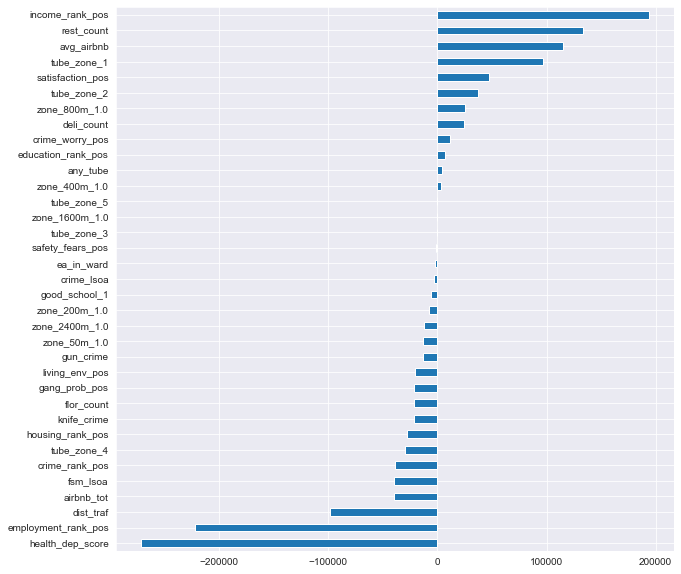

In [112]:
# the ElasticNet model has the best score by a tiny margin

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(elasticnet.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

The regularisation imposed by the Ridge, Lasso and Elasticnet models has reduced the huge coefficients seen in the Linear Regression model.

However the scores have barely improved. It could be that there are confounding factors within the data which didn't emerge during EDA. One possibility is that the different types of property are not distributed evenly across different postcodes.

We'll need to check this before going any further.

In [113]:
# check if distribution of houses, flats etc is uniform across london

groups = pd.DataFrame(latest_df.groupby(['borough', 'prop_type'])['price'].count()).reset_index()
groups = groups.rename(columns = {'price': 'count'})
groups.head()

borough prop_type  count
0  Barnet         D   1350
1  Barnet         F  11142
2  Barnet         S   3279
3  Barnet         T   2805
4  Bexley         D     27

In [114]:
# function to calculate the proportion of a specific sub-group

def divide_group(sub_series):
    return sub_series / sub_series.sum()

In [115]:
# apply function to each borough to establish what proportion of properties fall into each category

groups['perc_of_total'] = groups.groupby('borough')['count'].transform(divide_group).round(2)
groups

borough prop_type  count  perc_of_total
0         Barnet         D   1350           0.07
1         Barnet         F  11142           0.60
2         Barnet         S   3279           0.18
3         Barnet         T   2805           0.15
4         Bexley         D     27           0.03
..           ...       ...    ...            ...
107   Wandsworth         T   6496           0.23
108  Westminster         D     64           0.00
109  Westminster         F  14183           0.90
110  Westminster         S     97           0.01
111  Westminster         T   1372           0.09

[112 rows x 4 columns]

In [116]:
# segment the data by property type, so we can see clearly how the different boroughs compare

flats = groups[groups['prop_type'] == 'F']
detached = groups[groups['prop_type'] == 'D']
terrace = groups[groups['prop_type'] == 'T']
semi = groups[groups['prop_type'] == 'S']

In [117]:
# proportion of flats for each borough

flats.sort_values(by = 'perc_of_total')

borough prop_type  count  perc_of_total
65     Kingston upon Thames         F     38           0.26
5                    Bexley         F    236           0.27
89     Richmond upon Thames         F    854           0.36
32                  Enfield         F   3073           0.38
101          Waltham Forest         F   7455           0.46
77                   Merton         F   3872           0.47
85                Redbridge         F   1402           0.50
24                  Croydon         F   2663           0.52
53                 Hounslow         F   1381           0.56
28                   Ealing         F   6469           0.59
48                 Haringey         F   7538           0.59
1                    Barnet         F  11142           0.60
36                Greenwich         F  11990           0.60
73                 Lewisham         F  12238           0.63
13                  Bromley         F   2291           0.64
81                   Newham         F  12012           0.66
9                     Brent         F   6096           0.67
105              Wandsworth         F  20695           0.73
44   Hammersmith and Fulham         F   9302           0.75
69                  Lambeth         F  16117           0.77
61   Kensington and Chelsea         F   7914           0.80
93                Southwark         F  16151           0.80
57                Islington         F   8923           0.82
40                  Hackney         F  11665           0.83
17                   Camden         F   9968           0.85
109             Westminster         F  14183           0.90
97            Tower Hamlets         F  20586           0.94
20           City of London         F   1202           0.99
51                   Harrow         F      1           1.00

In [53]:
# proportion of detached houses for each borough

detached.sort_values(by = 'perc_of_total')

borough prop_type  count  perc_of_total
56                Islington         D     45           0.00
96            Tower Hamlets         D     20           0.00
80                   Newham         D     74           0.00
43   Hammersmith and Fulham         D     30           0.00
39                  Hackney         D     37           0.00
108             Westminster         D     64           0.00
68                  Lambeth         D    176           0.01
100          Waltham Forest         D    169           0.01
47                 Haringey         D    185           0.01
104              Wandsworth         D    263           0.01
60   Kensington and Chelsea         D     50           0.01
92                Southwark         D    190           0.01
72                 Lewisham         D    280           0.01
35                Greenwich         D    382           0.02
16                   Camden         D    181           0.02
12                  Bromley         D     83           0.02
8                     Brent         D    184           0.02
4                    Bexley         D     27           0.03
27                   Ealing         D    353           0.03
52                 Hounslow         D     78           0.03
23                  Croydon         D    192           0.04
84                Redbridge         D    115           0.04
31                  Enfield         D    300           0.04
76                   Merton         D    457           0.05
88     Richmond upon Thames         D    134           0.06
0                    Barnet         D   1350           0.07
64     Kingston upon Thames         D     36           0.25

In [54]:
# proportion of terraced houses for each borough

terrace.sort_values(by = 'perc_of_total')

borough prop_type  count  perc_of_total
22           City of London         T      8           0.01
99            Tower Hamlets         T   1197           0.05
111             Westminster         T   1372           0.09
67     Kingston upon Thames         T     16           0.11
19                   Camden         T   1250           0.11
42                  Hackney         T   2161           0.15
3                    Barnet         T   2805           0.15
95                Southwark         T   3153           0.16
59                Islington         T   1774           0.16
71                  Lambeth         T   3664           0.17
63   Kensington and Chelsea         T   1741           0.18
11                    Brent         T   1925           0.21
46   Hammersmith and Fulham         T   2872           0.23
107              Wandsworth         T   6496           0.23
30                   Ealing         T   2672           0.24
15                  Bromley         T    882           0.25
38                Greenwich         T   5593           0.28
75                 Lewisham         T   5421           0.28
87                Redbridge         T    820           0.29
55                 Hounslow         T    718           0.29
83                   Newham         T   5741           0.32
26                  Croydon         T   1758           0.34
50                 Haringey         T   4357           0.34
79                   Merton         T   3020           0.36
91     Richmond upon Thames         T    949           0.40
34                  Enfield         T   3323           0.42
103          Waltham Forest         T   7019           0.44
7                    Bexley         T    408           0.47

In [55]:
# proportion of semi-detached houses for each borough

semi.sort_values(by = 'perc_of_total')

borough prop_type  count  perc_of_total
21           City of London         S      1           0.00
98            Tower Hamlets         S     45           0.00
110             Westminster         S     97           0.01
62   Kensington and Chelsea         S    132           0.01
41                  Hackney         S    178           0.01
82                   Newham         S    296           0.02
58                Islington         S    164           0.02
45   Hammersmith and Fulham         S    216           0.02
18                   Camden         S    345           0.03
106              Wandsworth         S    922           0.03
94                Southwark         S    664           0.03
70                  Lambeth         S   1038           0.05
49                 Haringey         S    657           0.05
74                 Lewisham         S   1381           0.07
14                  Bromley         S    298           0.08
102          Waltham Forest         S   1406           0.09
10                    Brent         S    936           0.10
25                  Croydon         S    541           0.10
37                Greenwich         S   1996           0.10
54                 Hounslow         S    290           0.12
78                   Merton         S    973           0.12
29                   Ealing         S   1416           0.13
33                  Enfield         S   1310           0.16
86                Redbridge         S    472           0.17
90     Richmond upon Thames         S    425           0.18
2                    Barnet         S   3279           0.18
6                    Bexley         S    200           0.23
66     Kingston upon Thames         S     55           0.38

It looks like the boroughs have very different distributions of various property types.

For example, in Tower Hamlets 94% of sold properties are flats, but in Kingston the corresponding figure is only 26%.

What this means is that there probably isn't a single answer to the question 'How much will a properties value change if it were moved from postcode 1 to postcode 2?'

The answer will likely depend to a significant extent on what type of property it is. We will need to answer the question four times, once for each property type.

This means the model cannot rely only on features engineered from the postcode, we also need to include 'property type'.

In [11]:
# as property types are not evenly distributed, we need to add 'property type' to the list of features to model.
# create updated list of features

updated_features = ['prop_type', 'fsm_lsoa', 'ea_in_ward', 'avg_airbnb', 'airbnb_tot', 'crime_lsoa', 'deli_count', 'flor_count', 'rest_count', 'income_rank_pos','employment_rank_pos', 'education_rank_pos', 'health_dep_score', 'crime_rank_pos', 'housing_rank_pos', 'living_env_pos', 'zone_50m','zone_200m', 'zone_400m', 'zone_800m', 'zone_1600m', 'zone_2400m', 'dist_traf', 'gang_prob_pos', 'crime_worry_pos', 'safety_fears_pos', 'satisfaction_pos', 'gun_crime', 'knife_crime', 'good_school', 'tube_zone', 'any_tube']
updated_df = latest_df[updated_features]

In [124]:
# encode categorical columns

updated_df = pd.get_dummies(updated_df, drop_first=True)


# specify predictor matrix and target variable

X = updated_df
y = latest_df['price']

# get train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# standardize the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [125]:
# instantiate RidgeCV object, create param grid and grid search for best parameters

ridge_cv_2 = RidgeCV(alphas= np.logspace(-4, 4, 10), cv=5)
ridge_cv_2.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

In [126]:
# unsurprisingly the Ridge score has gone up since we introduced the property type as a predictor variable

ridge_cv_2.best_score_

0.26683910065306876

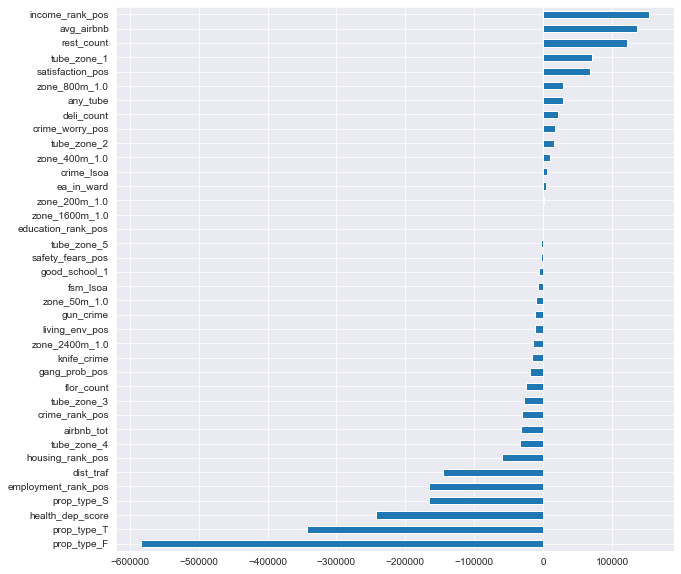

In [127]:
# check the Ridge coefficients

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(ridge_cv_2.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

In [129]:
# instantiate LassoCV object, search for best parameters

lasso_cv_2 = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5, n_jobs= -2, verbose = 3)
lasso_cv_2.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


(array([-3.47615928e+03,  0.00000000e+00,  1.49353207e+05, -0.00000000e+00,
       -0.00000000e+00,  2.66593908e+03, -2.82420744e+03,  1.16438812e+05,
        0.00000000e+00, -1.08272748e+04,  0.00000000e+00, -2.15167491e+05,
       -1.07397496e+04, -8.94584745e+03, -0.00000000e+00, -1.52018846e+05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.33442191e+04,
       -7.90740005e+01, -3.97007768e+03,  0.00000000e+00, -2.75104537e+05,
       -0.00000000e+00, -6.14328316e+04, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.27367715e+04, -0.00000000e+00, -4.87164854e+03,
       -0.00000000e+00,  5.13887373e+04,  1.42254514e+04, -4.97188322e+03,
       -1.19514870e+04,  0.00000000e+00]), 2722718943008.0, 20745572661150.9, 22)(array([-4.08114201e+03,  0.00000000e+00,  1.39154642e+05, -0.00000000e+00,
        0.00000000e+00,  5.21189618e+03, -2.86451525e+03,  1.04737382e+05,
        0.00000000e+00, -1.07527597e+04,  0.00000000e+00, -2.13056615e+05,
       -8.9797745

[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s


(array([  -6628.29783888,       0.        ,  145904.73647332,
            -0.        ,      -0.        ,    3144.53246038,
         -3138.52860844,  111148.11927619,       0.        ,
        -11736.70527388,       0.        , -215424.48320893,
         -9344.23871405,  -12300.09434878,      -0.        ,
       -152189.022024  ,       0.        ,       0.        ,
             0.        ,   56051.51543706,    -534.42689786,
         -2173.85245456,       0.        , -288256.42677034,
         -4960.75582166,  -72561.91808455,   -1709.37387216,
             0.        ,       0.        ,   15926.31764513,
            -0.        ,   -4124.25343546,      -0.        ,
         53335.7025797 ,   15002.38369767,   -3874.71771304,
        -12842.30020386,       0.        ]), 5483634168960.0, 20877036365247.457, 55)
(array([-9.62386012e+03,  4.63799408e+03,  1.39970331e+05, -2.72702810e+04,
        4.11233798e+02,  1.89843697e+04, -2.20756753e+04,  1.24494327e+05,
        1.27591186e+05, -1.382

[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    1.3s finished


LassoCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5, n_jobs=-2, verbose=3)

In [150]:
lasso_cv_2.alpha_

166.81005372000558

In [152]:
lasso_2 = Lasso(alpha = lasso_cv_2.alpha_)
lasso_2.fit(X_train, y_train)

Lasso(alpha=166.81005372000558)

In [153]:
# get cross validated scores for Lasso

scores = cross_val_score(lasso_2, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
lasso_2.fit(X_train, y_train)
print("Training Score:", lasso_2.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", lasso_2.score(X_test, y_test))

Cross-validated training scores: [0.24922856 0.26569125 0.2616466  0.28724419 0.27040749]
Mean cross-validated training score: 0.2668436181169554
Training Score: 0.2667560512636672
Test Score: 0.2133007263335297


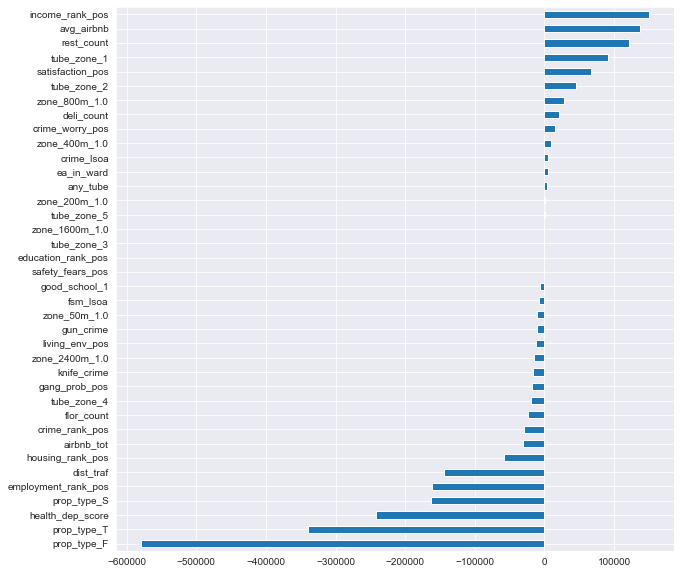

In [131]:
# check the Lasso coefficients

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lasso_cv_2.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

In [132]:
# instatiate ElasticNetCV object and set up param grid to search for best parameters

elasticnetcv_2 = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter=1000000, n_jobs= -2, verbose = 3)
# fit the model
elasticnetcv_2.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', elasticnetcv_2.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', elasticnetcv_2.l1_ratio_)
# evaluate on the training set
print('Training score:', elasticnetcv_2.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", elasticnetcv_2.score(X_test, y_test))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


(array([-11.69976335,  17.75571125,  33.79734073,  20.83023683,
         9.82891017,  18.4510732 ,  11.93643357,  24.05276142,
        25.69259896,  21.00980671,  22.33354761, -30.33070564,
        11.86701574,  18.69250765,  10.93045526, -24.63661093,
        16.55191233,  20.13495151,  21.14838161,  24.37409515,
       -10.36330995,   1.96843674,  13.38531143, -14.86578188,
         6.4894246 ,   8.255733  ,   0.04692031,   4.94938563,
        10.15758348,   8.54289862,  -3.97154077,  -4.01616243,
         2.39118522,  24.97595257,   3.04399558,  -7.88349626,
        -4.21364703,  -0.78991399]), 1792.0, 20745572661150.9, 3)
(array([ -90.26721941,  136.84569187,  260.83154919,  160.55402149,
         75.71800784,  142.27834112,   91.9468026 ,  185.65397471,
        198.10354608,  161.90830632,  172.11206928, -234.0983674 ,
         91.42104755,  144.05440107,   84.20714867, -190.03020079,
        127.65811274,  155.16002475,  162.98934248,  187.88225392,
        -79.888885  ,   15.184

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.815487050504774e+16, tolerance: 19778313970707.9
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4591537908139936e+16, tolerance: 20745572661150.9
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.01822546240136e+16, tolerance: 20216253609954.562
  model = cd_fast.enet_coordinate_descent_gram(


(array([-9.83064632e+03,  3.48831447e+03,  1.32706601e+05, -1.98103675e+04,
        3.15985361e+03,  2.26481252e+04, -2.46096864e+04,  1.06970362e+05,
        1.52709843e+05, -1.69433980e+05, -1.00340388e+02, -2.42971098e+05,
       -2.63924329e+04, -5.83615940e+04, -1.32591008e+04, -1.46368291e+05,
       -2.09677424e+04,  1.82756158e+04, -6.74123705e+03,  7.07409619e+04,
       -1.15079192e+04, -1.38040239e+04,  2.68162861e+04, -5.86041803e+05,
       -1.65870922e+05, -3.45632022e+05, -1.10427612e+04,  3.17949461e+03,
        9.08347590e+03,  2.70775093e+04,  9.76348876e+01, -1.49280320e+04,
       -6.81584194e+03,  6.64973589e+04,  1.70515672e+04, -2.65173127e+04,
       -3.34655220e+04, -2.16254891e+03]), 3.815487050504774e+16, 19778313970707.9, 1000000)
(array([-8.30412421e+03,  3.88984030e+03,  1.42285585e+05, -3.34234061e+04,
       -9.86323682e+02,  2.22444664e+04, -2.43989056e+04,  1.32610812e+05,
        1.49656443e+05, -1.58930854e+05, -2.49990468e+03, -2.41473348e+05,
     

(array([-9.82443132e+03,  3.48846186e+03,  1.32705497e+05, -1.98124642e+04,
        3.16105351e+03,  2.26478388e+04, -2.46109868e+04,  1.06970333e+05,
        1.52743123e+05, -1.69468694e+05, -1.00821549e+02, -2.42977780e+05,
       -2.63923406e+04, -5.83650235e+04, -1.32571563e+04, -1.46372903e+05,
       -2.09719861e+04,  1.82860603e+04, -6.75433883e+03,  7.07456034e+04,
       -1.15078152e+04, -1.38037756e+04,  2.68162627e+04, -5.86168238e+05,
       -1.65936012e+05, -3.45746933e+05, -1.10428390e+04,  3.17953913e+03,
        9.08319504e+03,  2.70776146e+04,  9.73952690e+01, -1.49278300e+04,
       -6.81514770e+03,  6.64956422e+04,  1.70514115e+04, -2.65164064e+04,
       -3.34642105e+04, -2.16312195e+03]), 19767251597952.0, 19778313970707.9, 59352)
(array([-12.88778033,  19.61585552,  37.43920875,  23.03174489,
        10.80894714,  20.38858455,  13.15041087,  26.61262499,
        28.43407975,  23.23116871,  24.70187709, -33.58766645,
        13.07329644,  20.65662246,  12.0327836 ,

(array([-12.79695808,  19.32783615,  36.69385671,  23.182604  ,
        11.39323874,  20.12060515,  13.14900962,  25.44278841,
        28.08379001,  22.85137345,  24.69677219, -33.190033  ,
        13.05043095,  20.37626402,  12.01013866, -27.21488363,
        18.27618134,  22.20585283,  23.34668114,  26.94387835,
       -11.44984671,   1.85194748,  14.81907674, -16.53061739,
         7.25066996,   9.0489099 ,  -0.        ,   5.11353491,
        11.37012165,   9.50708163,  -4.31429854,  -4.44300569,
         2.7737515 ,  27.67761227,   3.2428367 ,  -8.57329263,
        -4.59574525,  -0.81924261]), 160.0, 20216253609954.562, 3)
(array([ -99.44035109,  149.62409266,  283.81309777,  179.35119032,
         88.48730862,  155.82141663,  101.97705181,  197.04022398,
        217.18412269,  176.74830238,  190.97656519, -256.8217958 ,
        101.23216771,  157.68875212,   93.22120041, -210.57270437,
        141.64595688,  171.77246808,  180.58418876,  208.33410194,
        -88.96970385,   15.01

(array([-5.27581967e+03,  4.74118574e+03,  1.36732787e+05, -3.48340368e+04,
        4.83982168e+03,  2.07767231e+04, -2.60261681e+04,  1.23413508e+05,
        1.52030029e+05, -1.65132644e+05,  1.54496421e+03, -2.44927466e+05,
       -3.20477575e+04, -5.93315578e+04, -1.11216901e+04, -1.44132839e+05,
       -1.93445303e+04,  2.12453994e+04, -6.34214403e+03,  6.60203796e+04,
       -1.10133821e+04, -1.92379745e+04,  2.85670887e+04, -5.77114832e+05,
       -1.61295097e+05, -3.36848584e+05, -9.49090513e+03,  4.98957483e+02,
        1.02312911e+04,  2.88839970e+04,  3.33830014e+01, -1.46552800e+04,
       -5.73154179e+03,  7.31364372e+04,  1.56176050e+04, -2.77333821e+04,
       -3.46940903e+04, -2.84977512e+03]), 20931791997056.0, 20948566362878.5, 59008)
(array([-1.31919755e+01,  1.96592635e+01,  3.73432656e+01,  2.28623344e+01,
        1.10408610e+01,  2.02708732e+01,  1.30673042e+01,  2.61164628e+01,
        2.85636744e+01,  2.33535232e+01,  2.48411968e+01, -3.37907992e+01,
        1.31

(array([-22.4549627 ,  33.28774217,  64.92582965,  40.15676933,
        17.87511249,  34.58000406,  22.21098785,  43.43416002,
        49.77749966,  40.41066988,  43.63153587, -59.20914217,
        23.24819572,  35.70444946,  20.04063849, -47.85224942,
        31.91274374,  38.97829775,  41.05236432,  47.57029407,
       -19.71113907,   1.79353399,  25.5736485 , -29.19212247,
        12.49200999,  15.46365126,  -0.        ,   9.1848314 ,
        18.94655336,  16.00297518,  -6.67038622,  -7.31978437,
         4.23830873,  48.21744798,   5.36344076, -14.635289  ,
        -7.50434538,  -0.57867586]), 1760.0, 19778313970707.9, 3)
(array([-179.32189039,  262.03220099,  506.10532483,  314.84924805,
        143.68764192,  272.23272645,  176.87901937,  340.81967963,
        388.89730381,  316.61963099,  341.37097313, -462.24041007,
        184.91187844,  280.53016449,  160.27632191, -374.41719483,
        251.86312103,  305.63194253,  321.61692722,  371.75664038,
       -157.97583596,   20.451

(array([-8.27349081e+03,  3.89079341e+03,  1.42281058e+05, -3.34371025e+04,
       -9.79898778e+02,  2.22423151e+04, -2.44051571e+04,  1.32614052e+05,
        1.49817926e+05, -1.59097842e+05, -2.50195355e+03, -2.41505822e+05,
       -3.26225528e+04, -5.81988334e+04, -1.29970904e+04, -1.45661097e+05,
       -1.96955719e+04,  1.62145336e+04, -2.86573085e+03,  6.60287205e+04,
       -1.13117592e+04, -1.61072103e+04,  2.71551113e+04, -5.76282992e+05,
       -1.63185599e+05, -3.38500266e+05, -9.72784834e+03,  1.87958479e+03,
        9.01230608e+03,  2.71364186e+04,  4.22655826e+02, -1.41558581e+04,
       -6.98199959e+03,  6.90129847e+04,  1.62938294e+04, -2.75351646e+04,
       -3.29820545e+04, -2.75797807e+03]), 20741503776672.0, 20745572661150.9, 79638)
(array([-22.22416664,  33.96985715,  65.22148198,  40.90533477,
        19.69547311,  35.39843509,  22.85304086,  44.97860309,
        49.72423189,  40.30789981,  43.62807461, -58.91811528,
        22.67593049,  35.85553432,  20.80476256,

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7548473073268800.0, tolerance: 20877036365247.457
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1457049337914832e+16, tolerance: 20948566362878.5
  model = cd_fast.enet_coordinate_descent_gram(


(array([-4.75023709e+03,  4.02961735e+03,  1.32005849e+05, -3.15843607e+04,
        1.34820656e+04,  2.15176503e+04, -2.37253233e+04,  1.16304751e+05,
        1.56329174e+05, -1.67132129e+05,  1.22883807e+03, -2.40027456e+05,
       -2.93037231e+04, -5.85675025e+04, -1.14570258e+04, -1.43344020e+05,
       -1.71137629e+04,  1.60373691e+04, -1.77093507e+03,  6.62367817e+04,
       -1.11888765e+04, -1.87068238e+04,  2.89149939e+04, -5.83758569e+05,
       -1.65885282e+05, -3.43844547e+05, -9.59244309e+03,  9.84909163e+02,
        1.06077162e+04,  2.80836441e+04,  4.94114051e+02, -1.44483100e+04,
       -5.87201977e+03,  7.20544261e+04,  1.63306312e+04, -2.73734834e+04,
       -3.46345934e+04, -2.87765906e+03]), 20214158026208.0, 20216253609954.562, 79265)
(array([-22.93493884,  34.5663038 ,  66.39021513,  40.32883179,
        19.06124337,  35.66885319,  22.70600711,  46.19105279,
        50.58758358,  41.21129822,  43.8877715 , -59.99904308,
        22.90990786,  36.03861667,  20.5921628

(array([-36.73199154,  54.76338697, 107.47513538,  66.20436042,
        29.09598011,  56.92123176,  36.31450178,  71.67869395,
        82.22934928,  66.62297022,  71.9873653 , -97.95513347,
        38.04281805,  58.78659136,  32.7015099 , -79.02985031,
        52.48103438,  64.23816348,  67.6933795 ,  78.54997466,
       -32.15708542,   2.31941423,  41.92396696, -47.99177198,
        20.15450126,  25.11128873,  -0.        ,  14.62596057,
        30.88367047,  25.98782043, -10.43883953, -11.52526189,
         6.38900705,  79.64025711,   8.26302119, -23.70627503,
       -11.83342273,  -0.29447745]), 13312.0, 19778313970707.9, 3)
(array([-2.96597148e+02,  4.33002573e+02,  8.38676781e+02,  5.20573635e+02,
        2.36999100e+02,  4.50246788e+02,  2.91842466e+02,  5.64596539e+02,
        6.43427289e+02,  5.23272723e+02,  5.64293341e+02, -7.66059640e+02,
        3.05228201e+02,  4.63561581e+02,  2.64424868e+02, -6.19835533e+02,
        4.16643525e+02,  5.05095188e+02,  5.31644269e+02,  6.148

(array([-36.61978448,  56.76276729, 110.2027829 ,  66.99749258,
        30.37561194,  59.08768274,  37.38769382,  77.7600809 ,
        83.19036433,  67.58998694,  71.99611476, -98.66228531,
        37.15728896,  59.87861884,  34.04171296, -79.68601069,
        52.76837107,  64.67813653,  68.05364749,  78.79422813,
       -32.16101405,   4.2208988 ,  42.22700604, -47.22816504,
        19.30076262,  25.19502358,   0.        ,  14.13736669,
        31.47591598,  26.11239552, -10.88342118, -11.04055166,
         5.62338771,  80.82001144,   7.7969853 , -23.91069707,
       -11.69921245,  -0.29385116]), 13664.0, 20745572661150.9, 3)
(array([-295.74943577,  448.31059597,  859.67537642,  526.49614845,
        246.71092685,  466.84423721,  300.02716483,  611.45667619,
        650.79027522,  530.68289737,  564.30050466, -771.49826319,
        298.36868933,  471.94381519,  274.66230628, -624.79378284,
        418.83737321,  508.42355606,  534.36915811,  616.6221534 ,
       -260.89678181,   47.79

(array([-4.87421117e+03,  4.02429761e+03,  1.32024721e+05, -3.15311867e+04,
        1.34501527e+04,  2.15241006e+04, -2.37029851e+04,  1.16299965e+05,
        1.55708661e+05, -1.66498671e+05,  1.23648413e+03, -2.39908545e+05,
       -2.93031268e+04, -5.84987224e+04, -1.14888838e+04, -1.43260131e+05,
       -1.70430586e+04,  1.58528963e+04, -1.54629596e+03,  6.61662487e+04,
       -1.11920415e+04, -1.87047934e+04,  2.89134112e+04, -5.81454928e+05,
       -1.64698575e+05, -3.41751551e+05, -9.59406781e+03,  9.83172504e+02,
        1.06107823e+04,  2.80800699e+04,  4.96880692e+02, -1.44542046e+04,
       -5.88602718e+03,  7.20821305e+04,  1.63342380e+04, -2.73876804e+04,
       -3.46585270e+04, -2.86397397e+03]), 20204033638496.0, 20216253609954.562, 18504)
(array([-36.56573466,  55.64090308, 108.78855762,  66.16109226,
        30.14965196,  57.69894891,  36.88214082,  75.11403685,
        82.57062407,  66.96369375,  72.17311042, -98.33589936,
        37.2089492 ,  59.3458441 ,  33.6018474

(array([-37.53171933,  56.89298515, 109.914629  ,  66.4897115 ,
        31.07135029,  58.73469001,  37.1388816 ,  76.27203244,
        83.57848749,  67.95630645,  72.41375332, -99.27082886,
        37.47893463,  59.34281745,  33.61983093, -79.56269278,
        52.72560152,  64.41119577,  67.88159998,  78.7400649 ,
       -32.1691086 ,   3.95428019,  42.69313947, -47.99183457,
        19.95608852,  25.23761013,  -0.        ,  13.96574769,
        30.70881466,  27.16928998, -10.82524311, -10.97782421,
         5.66354528,  80.82417016,   7.76550098, -23.46087506,
       -11.66151512,  -0.35326949]), 13760.0, 20877036365247.457, 3)
(array([-3.02759857e+02,  4.49318082e+02,  8.57417158e+02,  5.22599615e+02,
        2.52096074e+02,  4.64121438e+02,  2.98141326e+02,  5.99969411e+02,
        6.53743775e+02,  5.33460764e+02,  5.67509671e+02, -7.76142953e+02,
        3.00855242e+02,  4.67774656e+02,  2.71420164e+02, -6.23825749e+02,
        4.18501884e+02,  5.06354759e+02,  5.33035552e+02,  6.1

(array([-107.46919817,  167.52936021,  327.5803346 ,  198.11776029,
         88.66837227,  174.56423165,  109.59447459,  230.58378451,
        246.56961677,  199.84333001,  213.00811423, -293.08514193,
        108.9115534 ,  176.81905864,   99.61829831, -236.18958717,
        155.70131518,  191.14473424,  201.24948297,  233.37152793,
        -94.0593299 ,   10.60141192,  124.19563939, -139.76330036,
         55.92632888,   73.6651598 ,    0.        ,   40.1810493 ,
         92.00968902,   76.07847509,  -30.4660794 ,  -31.00889698,
         14.75220056,  239.61590321,   21.25256403,  -69.4419991 ,
        -32.98836305,   -0.        ]), 1059744.0, 20745572661150.9, 3)
(array([ -862.03745568,  1297.73601137,  2516.01453884,  1525.41961919,
         710.6656301 ,  1356.79059926,   864.22917433,  1790.79835126,
        1891.01731216,  1535.17997584,  1632.82728323, -2259.03811539,
         859.95776891,  1365.33082714,   791.72505855, -1820.73299669,
        1218.66364369,  1470.4932561 ,  

(array([-106.65689624,  164.94323728,  320.87841662,  199.48177044,
         93.92446712,  172.15734182,  109.58614703,  220.0686918 ,
        243.43101695,  196.43972467,  212.97164126, -289.51867214,
        108.71525582,  174.30464093,   99.42040136, -235.77422973,
        155.68583219,  190.66708301,  200.90559332,  233.14739797,
        -94.48434596,    8.58655221,  124.72290774, -140.88106023,
         57.28704605,   73.54710417,   -0.        ,   37.72166419,
         93.7723215 ,   77.21523223,  -30.58523269,  -31.834629  ,
         16.80252286,  239.97658146,   20.99751442,  -68.77425673,
        -33.21494258,   -0.        ]), 1049568.0, 20216253609954.562, 3)
(array([-8.56030577e+02,  1.27805263e+03,  2.46446728e+03,  1.53632957e+03,
        7.51197276e+02,  1.33842583e+03,  8.64405413e+02,  1.71015671e+03,
        1.86751277e+03,  1.50965928e+03,  1.63307446e+03, -2.23211987e+03,
        8.58981230e+02,  1.34635819e+03,  7.90527978e+02, -1.81749000e+03,
        1.21890307e+03

(array([-5.26762200e+03,  4.74143106e+03,  1.36731477e+05, -3.48376184e+04,
        4.84175815e+03,  2.07762610e+04, -2.60278228e+04,  1.23414027e+05,
        1.52071912e+05, -1.65176161e+05,  1.54465212e+03, -2.44936187e+05,
       -3.20479104e+04, -5.93360132e+04, -1.11193777e+04, -1.44138380e+05,
       -1.93498655e+04,  2.12587411e+04, -6.35826484e+03,  6.60254710e+04,
       -1.10132374e+04, -1.92380568e+04,  2.85684497e+04, -5.77271228e+05,
       -1.61375654e+05, -3.36990755e+05, -9.49126842e+03,  4.97147771e+02,
        1.02281095e+04,  2.88804421e+04,  2.94488592e+01, -1.46576182e+04,
       -5.73068921e+03,  7.31366290e+04,  1.56201174e+04, -2.77298955e+04,
       -3.46910629e+04, -2.85044318e+03]), 20948063229280.0, 20948566362878.5, 38358)
(array([-110.19916502,  167.9199705 ,  326.71298552,  196.59846843,
         90.75556616,  173.50653203,  108.85258835,  226.12357602,
        247.72807547,  200.93563286,  214.25816799, -294.90312192,
        109.8759078 ,  175.20931358,

(array([-213.43960479,  319.90851907,  634.81285648,  388.00577167,
        167.41049464,  333.15693723,  210.1330653 ,  421.74030994,
        483.44360826,  390.1770425 ,  422.08862638, -578.27007037,
        220.47460811,  343.70198623,  188.77113141, -464.93624712,
        306.90248662,  376.05508707,  396.67054311,  461.31858087,
       -185.85456556,    8.68393117,  244.16250697, -283.30484727,
        116.00851195,  146.04591234,   -0.        ,   81.61280516,
        178.28166378,  149.65549182,  -56.75820004,  -63.5792491 ,
         32.72854974,  468.72587473,   43.88492758, -135.81521091,
        -65.4713647 ,   -0.        ]), 15911232.0, 19778313970707.9, 3)
(array([-1662.18820181,  2382.6244943 ,  4739.09683544,  2876.78580889,
        1292.09104687,  2502.54833631,  1588.39838987,  3190.76043133,
        3573.97860266,  2874.60966743,  3105.04907839, -4336.30196929,
        1667.89578962,  2546.69865028,  1441.6586879 , -3471.54391655,
        2324.04345059,  2776.3268429 , 

(array([-8.26656230e+03,  3.89100893e+03,  1.42280035e+05, -3.34401909e+04,
       -9.78448062e+02,  2.22418277e+04, -2.44065683e+04,  1.32614780e+05,
        1.49854418e+05, -1.59135574e+05, -2.50241535e+03, -2.41513150e+05,
       -3.26226770e+04, -5.82029842e+04, -1.29951623e+04, -1.45666597e+05,
       -1.97001778e+04,  1.62256358e+04, -2.87962129e+03,  6.60334123e+04,
       -1.13116331e+04, -1.61072267e+04,  2.71574700e+04, -5.76425120e+05,
       -1.63258824e+05, -3.38629423e+05, -9.72857916e+03,  1.87582044e+03,
        9.00613547e+03,  2.71288883e+04,  4.14871033e+02, -1.41608541e+04,
       -6.98116895e+03,  6.90150892e+04,  1.62990780e+04, -2.75291717e+04,
       -3.29777983e+04, -2.75822480e+03]), 20743950676512.0, 20745572661150.9, 55706)
(array([-211.16476311,  326.64696383,  637.71799372,  395.38114243,
        185.48247237,  341.25068761,  216.49410565,  437.09859839,
        482.91877129,  389.15994988,  422.05376068, -575.38545524,
        214.78767435,  345.20331378,

[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   17.7s


(array([-212.45043574,  325.12589532,  642.66968867,  387.68371316,
        173.64440072,  337.77082883,  213.50351382,  442.28046169,
        485.47836209,  392.20786999,  423.18928983, -580.5589377 ,
        215.47782256,  347.03202301,  194.13891778, -467.74650136,
        307.65098847,  378.09611383,  397.68797774,  461.96745839,
       -186.55847075,    9.86427478,  245.47730095, -285.01608219,
        115.77250723,  150.29719453,   -0.        ,   75.43291867,
        182.96020714,  152.29207323,  -60.53169922,  -61.148847  ,
         30.97843582,  476.84236653,   39.62925645, -136.41009439,
        -65.22017495,   -0.        ]), 16110304.0, 20948566362878.5, 3)
(array([-1.65500690e+03,  2.42024235e+03,  4.79857094e+03,  2.87067356e+03,
        1.33514755e+03,  2.53521835e+03,  1.61241605e+03,  3.34554954e+03,
        3.58899123e+03,  2.88955517e+03,  3.11277607e+03, -4.35428198e+03,
        1.62961518e+03,  2.57097822e+03,  1.48124285e+03, -3.49124021e+03,
        2.32999936e+03,

(array([-1.03465314e+04,  6.39974538e+03,  1.38629594e+05, -3.83300055e+04,
        7.96521518e+03,  2.06653911e+04, -2.44438431e+04,  1.25933185e+05,
        1.53968313e+05, -1.64921520e+05, -2.46956829e+02, -2.42683955e+05,
       -3.10295798e+04, -6.25840641e+04, -1.32044638e+04, -1.45216052e+05,
       -2.15327805e+04,  1.38646878e+04, -4.18524570e+02,  6.94815975e+04,
       -1.13812084e+04, -1.65426289e+04,  2.87082148e+04, -5.93799294e+05,
       -1.70930907e+05, -3.53246793e+05, -1.14931969e+04,  1.61595837e+03,
        7.59287588e+03,  2.97459631e+04,  3.58693031e+02, -1.37949333e+04,
       -6.77464097e+03,  7.14727050e+04,  1.66410214e+04, -2.74674675e+04,
       -3.45398222e+04, -3.07000168e+03]), 20876527657056.0, 20877036365247.457, 55596)
(array([-1018.58467189,  1512.51323936,  3055.91327344,  1840.66666605,
         784.14169257,  1585.48391296,   984.4493227 ,  2029.12252907,
        2301.36310813,  1843.51973109,  1996.94729289, -2785.98569884,
        1035.31987732,

(array([-1015.53520159,  1569.73282707,  3135.76379248,  1860.98427554,
         819.40257477,  1647.62451073,  1014.6819332 ,  2207.92339884,
        2328.94623181,  1871.29967115,  1996.23236211, -2806.58749026,
        1008.6998955 ,  1655.0928013 ,   922.86270745, -2242.65018849,
        1470.85972051,  1789.49649383,  1887.77288177,  2196.24061524,
        -877.59040444,    89.2587475 ,  1171.19755865, -1397.38444083,
         552.77059115,   736.79867628,    -0.        ,   363.54879512,
         857.98056989,   718.80134404,  -272.3017533 ,  -286.72624064,
         123.60864968,  2279.65867429,   186.28056118,  -648.74199533,
        -307.13793812,    -0.        ]), 343283392.0, 20745572661150.9, 4)
(array([ -6342.14781175,   8806.05467716,  19453.83851291,  10469.57382582,
         4575.15516233,   9678.05622467,   5537.0001493 ,  13972.78555848,
        13359.65579885,  10242.86059965,  10950.31468486, -17517.32683534,
         5515.55191927,   9137.51199245,   5161.16456146, -

(array([-1007.89881099,  1544.46972445,  3069.36882191,  1875.22865619,
         871.72415516,  1624.04654784,  1015.0068214 ,  2104.08994616,
        2298.90956879,  1838.66253076,  1996.77625656, -2772.10220278,
        1007.6404471 ,  1630.80234248,   921.4500494 , -2238.49508166,
        1471.30872713,  1784.95062152,  1884.57897936,  2194.25825851,
        -881.9766417 ,    69.20617177,  1176.41018573, -1408.55234834,
         566.24951744,   735.59084599,    -0.        ,   339.76507242,
         875.55066748,   729.87345714,  -273.72724011,  -294.80387074,
         143.75001208,  2283.75637657,   183.43768863,  -642.25897974,
        -309.33398012,    -0.        ]), 343019968.0, 20216253609954.562, 4)
(array([ -6301.60019472,   8638.87590189,  18970.59416047,  10603.93186916,
         4968.9315211 ,   9519.36624696,   5555.127423  ,  13231.11970962,
        13183.72922819,  10048.60009632,  10990.76805574, -17300.12779809,
         5542.62357468,   8986.27022638,   5173.25690375,

(array([-5.25621992e+03,  4.74177053e+03,  1.36729660e+05, -3.48425570e+04,
        4.84442652e+03,  2.07756136e+04, -2.60301152e+04,  1.23414739e+05,
        1.52130081e+05, -1.65236589e+05,  1.54420013e+03, -2.44948288e+05,
       -3.20481124e+04, -5.93421870e+04, -1.11161527e+04, -1.44146088e+05,
       -1.93572530e+04,  2.12772488e+04, -6.38061695e+03,  6.60325150e+04,
       -1.10130346e+04, -1.92381589e+04,  2.85760885e+04, -5.77488670e+05,
       -1.61487652e+05, -3.37188419e+05, -9.49394745e+03,  4.82269064e+02,
        1.02045998e+04,  2.88509351e+04,  0.00000000e+00, -1.46776173e+04,
       -5.72949728e+03,  7.31509860e+04,  1.56433390e+04, -2.77069077e+04,
       -3.46767508e+04, -2.84925483e+03]), 20947070945952.0, 20948566362878.5, 11045)
(array([-4.72131340e+03,  4.03085814e+03,  1.32001440e+05, -3.15966746e+04,
        1.34894597e+04,  2.15161541e+04, -2.37305213e+04,  1.16305825e+05,
        1.56473789e+05, -1.67279686e+05,  1.22705182e+03, -2.40055011e+05,
       -2.93

(array([-1.03271775e+04,  6.40090575e+03,  1.38626469e+05, -3.83396619e+04,
        7.97059844e+03,  2.06637865e+04, -2.44478092e+04,  1.25934603e+05,
        1.54071416e+05, -1.65027725e+05, -2.48580347e+02, -2.42704067e+05,
       -3.10297243e+04, -6.25959034e+04, -1.31987068e+04, -1.45230810e+05,
       -2.15456717e+04,  1.38949858e+04, -4.56484762e+02,  6.94952344e+04,
       -1.13808523e+04, -1.65427182e+04,  2.87186460e+04, -5.94203848e+05,
       -1.71139298e+05, -3.53614365e+05, -1.14964084e+04,  1.59996328e+03,
        7.56709143e+03,  2.97138451e+04,  3.26070816e+02, -1.38164827e+04,
       -6.77232997e+03,  7.14847544e+04,  1.66639047e+04, -2.74439379e+04,
       -3.45242578e+04, -3.06979543e+03]), 20876190896000.0, 20877036365247.457, 19448)
(array([  -4950.22376903,       0.        ,  140510.92981836,
             0.        ,      -0.        ,    5217.78904949,
         -3788.14090436,   96531.80589654,       0.        ,
        -13694.6251864 ,       0.        , -214949.3

(array([  -3070.51738707,       0.        ,  144124.73214866,
            -0.        ,      -0.        ,    2825.68136838,
         -4220.07018344,  108471.67676575,       0.        ,
        -11949.06842113,       0.        , -217244.54757799,
        -10924.84131061,  -10630.76873612,      -0.        ,
       -152761.97804221,       0.        ,       0.        ,
             0.        ,   55293.42255532,    -341.27822011,
         -5190.79272875,       0.        , -279342.51571809,
            -0.        ,  -62904.52896384,      -0.        ,
            -0.        ,       0.        ,   14382.97126448,
            -0.        ,   -5225.49962266,      -0.        ,
         56624.68469491,   14414.18592035,   -4008.62173547,
        -13027.70250016,       0.        ]), 1514236340800.0, 20948566362878.5, 22)
(array([  -4827.05478712,    3459.09065422,  138212.37583314,
        -25391.28007974,       0.        ,   18723.60599476,
        -23491.55343387,  121605.05507162,  125684.65711852,

[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   21.4s finished


Best alpha: 166.81005372000558
Best l1-ratio: 1.0
Training score: 0.2667560512636672
Test Score: 0.2133007263335297


In [133]:
# create an ElasticNet model instance
elasticnet_2 = ElasticNet(alpha = elasticnetcv_2.alpha_, l1_ratio = elasticnetcv_2.l1_ratio_)

# get cross validated scores
scores = cross_val_score(elasticnet_2, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
elasticnet_2.fit(X_train, y_train)
print("Training Score:", elasticnet_2.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", elasticnet_2.score(X_test, y_test))

Cross-validated training scores: [0.24922856 0.26569125 0.2616466  0.28724419 0.27040749]
Mean cross-validated training score: 0.2668436181169554
Training Score: 0.2667560512636672
Test Score: 0.2133007263335297


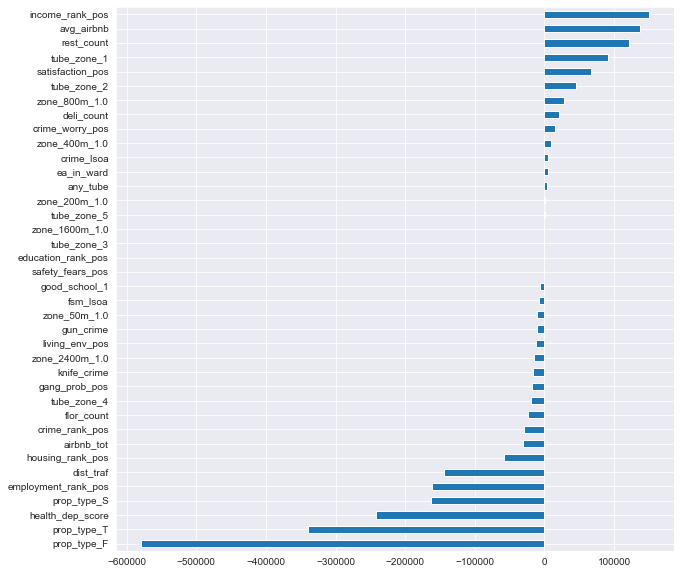

In [134]:
# check the ElasticNet coefficients

# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(elasticnet_2.coef_, index = X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize = (10,10))
df_coef['coefficients'].sort_values().plot(kind='barh', ax = ax);

One of the reasons that we chose the period 2015-2020 was the relative price stability during this time. There isn't a strong underlying trend that would seemingly require a Time Series model.

Within the period, prices are almost static from 2017-20, but there is a slight upward movement from 2015-17.

We can try dropping 2015 and 2016 to see if this helps the models score higher.


In [161]:
# check if reducing the data to 2017-2020 (when there was almost no price movement) helps the model

reduced_df = latest_df[latest_df['year'] >= 2017]
reduced_df.shape

(191738, 45)

In [178]:
# specify predictor matrix and target variable

y = reduced_df['price']
X = reduced_df[updated_features]

# encode categorical columns

X = pd.get_dummies(X, drop_first=True)

#train test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# standardize the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [180]:
# Elasticnet was the most successful model by a fraction, refit on new reduced dataset

elasticnetcv_3 = ElasticNetCV(alphas=np.logspace(-4, 4, 10), 
                     l1_ratio=np.array([0.00001, .1, .5, .7, .9, .95, .99, 1]),
                     cv=5, max_iter=1000000, n_jobs= -2, verbose = 3)
# fit the model
elasticnetcv_3.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', elasticnetcv_3.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', elasticnetcv_3.l1_ratio_)
# evaluate on the training set
print('Training score:', elasticnetcv_3.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", elasticnetcv_3.score(X_test, y_test))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


(array([-11.2848441 ,  18.36346649,  34.24992064,  21.21754289,
         9.6094417 ,  18.50627158,  12.2525161 ,  25.0045714 ,
        25.50948891,  20.77435531,  22.3612521 , -30.44703211,
        12.21424205,  18.13292092,  11.809091  , -25.11751269,
        16.6140447 ,  20.52257808,  21.43363701,  24.52471109,
       -10.29469094,   1.51154986,  13.5637115 , -15.01048015,
         6.47996947,   8.1005758 ,  -0.49056647,   5.83885645,
         9.92984452,   9.13566813,  -4.28284641,  -4.49688282,
         2.16227531,  26.04114326,   2.34709515,  -7.99077283,
        -4.29230735,  -0.58939584]), 1568.0, 15342476190834.008, 3)
(array([-11.29518338,  18.70912899,  33.56813713,  21.1627425 ,
         9.51612776,  18.87371298,  12.52563208,  25.21318521,
        25.20088189,  20.6145414 ,  22.13606789, -29.67192455,
        12.73658001,  18.28301316,  11.48994181, -24.69106566,
        16.16412219,  19.95187535,  21.01186578,  24.15958173,
       -10.06658221,   2.05990473,  13.43728529,

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.654300668580644e+16, tolerance: 15342476190834.008
  model = cd_fast.enet_coordinate_descent_gram(


(array([  16759.36816053,    6478.8665554 ,  141428.99575186,
        -39047.07277786,   17086.11964506,   20348.50809853,
        -26666.85770606,  135021.45920141,  162430.932443  ,
       -169795.76027522,   -2778.4580362 , -247561.57122774,
        -32970.36668415,  -54545.65656866,   -8274.5097613 ,
       -137646.4545018 ,  -13941.69062336,   32995.52624285,
         -4146.24306249,   47348.53163755,  -13894.90641489,
        -25967.58578837,   30269.14437861, -611291.54515693,
       -180450.28247577, -368632.96584615,  -10889.65230849,
          6720.35130878,    7637.23877359,   28976.55469333,
           982.54942431,  -15253.00629744,   -9017.97042002,
         76883.00477568,   12542.57298137,  -26466.83710604,
        -34549.70326105,   -2686.10252706]), 1.654300668580644e+16, 15342476190834.008, 1000000)
(array([-11.51327921,  19.02303895,  34.72023049,  21.20125945,
         9.68387972,  19.15007533,  12.5438249 ,  26.51039295,
        25.8768978 ,  21.18812738,  22.4873

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5114201091351864e+16, tolerance: 14945670080838.209
  model = cd_fast.enet_coordinate_descent_gram(


(array([   7262.93330735,    9099.0327433 ,  138847.2279743 ,
        -24137.95299917,    2069.86451053,   26276.18732847,
        -22394.02564169,  135238.76127666,  150263.25117999,
       -156369.80100952,   -5094.80247806, -239806.05262978,
        -27437.77391166,  -58982.83223255,  -11762.7910977 ,
       -139213.212073  ,  -14474.42459184,   25766.19336626,
           941.28110442,   51565.27884348,  -14439.36235456,
        -18251.92144176,   27648.1871811 , -623718.92828688,
       -186883.20089347, -376252.17756632,  -11079.03107958,
          5192.38116204,    4459.00691774,   29251.81948936,
          1549.06974775,  -15234.27379835,   -6645.71477484,
         67727.97065122,   15000.44497876,  -25413.78408564,
        -32527.94174765,   -3334.33800066]), 2.5114201091351864e+16, 14945670080838.209, 1000000)


/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6245865674810784e+16, tolerance: 12748792334242.53
  model = cd_fast.enet_coordinate_descent_gram(


(array([ 5.59769885e+03,  1.03750990e+04,  1.36242355e+05, -2.93674156e+04,
        9.54538865e+03,  2.28269927e+04, -2.21054639e+04,  1.30662905e+05,
        1.45841165e+05, -1.54089766e+05, -5.81971866e+03, -2.34499951e+05,
       -2.28395882e+04, -5.05871906e+04, -7.07578917e+03, -1.39716572e+05,
       -1.56287614e+04,  2.26531750e+04, -5.34363221e+03,  5.79703887e+04,
       -1.35172051e+04, -1.72071195e+04,  2.71111300e+04, -6.07071608e+05,
       -1.78614757e+05, -3.64861152e+05, -1.13509123e+04,  2.20664763e+03,
        6.77296933e+03,  2.88308900e+04, -7.71474123e+01, -1.33400996e+04,
       -8.34512303e+03,  6.90287066e+04,  1.43097398e+04, -2.65410522e+04,
       -3.20311596e+04, -2.61957891e+03]), 1.6245865674810784e+16, 12748792334242.53, 1000000)
(array([-11.17569357,  18.15756826,  33.24358115,  20.89789849,
         9.12887836,  18.03218042,  12.13854846,  23.78329402,
        25.28025908,  20.6043093 ,  22.40653173, -29.91485351,
        12.13815067,  18.41281657,  11.

(array([  12221.34885321,    9764.56032747,  136346.5079503 ,
        -28303.62295941,   12678.71035587,   17835.63241229,
        -24135.22720433,  133022.53893916,  154926.28830211,
       -165699.69730498,   -1691.54346516, -242377.23885955,
        -31235.72712811,  -49437.89982529,   -8952.94342746,
       -140110.62232605,  -14071.49902917,   31359.29770481,
         -9087.65443639,   52058.6656727 ,  -13808.01097865,
        -23053.20752112,   28817.07361776, -616982.3267173 ,
       -183706.42543976, -371420.42610772,  -10389.29034296,
          7997.26697916,    7798.12264258,   27940.70595049,
         -1052.68229495,  -13996.7135113 ,   -8786.92655877,
         71641.7520867 ,   13823.34874452,  -25835.13620384,
        -33132.19536244,   -2981.64363692]), 10949520942800.0, 15444625464567.943, 13488)
(array([   6809.03939901,    9091.55237716,  138898.40374868,
        -23994.45794906,    1970.25277705,   26301.44022418,
        -22309.36657263,  135204.48347102,  148276.051

(array([  16768.34567235,    6478.9571804 ,  141427.9547226 ,
        -39050.39973685,   17088.57256115,   20347.95775007,
        -26668.44920425,  135021.99861416,  162468.82651757,
       -169833.86676852,   -2778.58762186, -247568.43897425,
        -32970.37368526,  -54548.7098725 ,   -8272.36940418,
       -137650.24458707,  -13945.27256986,   33008.7656492 ,
         -4160.2046052 ,   47350.30606839,  -13894.7426085 ,
        -25967.86728911,   30269.48217579, -611426.87174203,
       -180520.83678128, -368755.98849212,  -10889.42401415,
          6720.3566416 ,    7637.08359887,   28976.81463327,
           982.35255757,  -15252.76092157,   -9017.08280707,
         76881.61173018,   12542.54272303,  -26465.81311926,
        -34548.57133454,   -2687.25917491]), 15335388884832.0, 15342476190834.008, 60095)
(array([-12.43824892,  20.67518324,  37.18452964,  23.40119369,
        10.4614578 ,  20.85817278,  13.80504496,  27.9019529 ,
        27.88775368,  22.79201544,  24.48247068, -

(array([-12.68055922,  21.02393512,  38.46457287,  23.44396777,
        10.64783364,  21.16520559,  13.82523563,  29.3432646 ,
        28.63883089,  23.42928283,  24.87268915, -33.97243074,
        13.70537383,  20.55206876,  13.03798622, -27.79975543,
        18.09657053,  22.52567903,  23.57774216,  27.12078921,
       -11.35256456,   2.447224  ,  15.04381072, -16.66649278,
         7.12088547,   9.02425423,  -0.46290927,   6.40832962,
        11.25733182,  10.05780078,  -4.89542676,  -4.84259985,
         1.98195384,  28.50374742,   2.77001533,  -8.73572347,
        -4.63453371,  -0.64843501]), 128.0, 15896243005688.88, 3)
(array([ -98.52502651,  162.72716149,  297.4882511 ,  181.36114345,
         82.7355587 ,  163.885281  ,  107.18457092,  227.21344482,
        221.45933798,  181.20310973,  192.31552017, -262.86410282,
        106.27911662,  159.05502339,  101.1490246 , -215.07228376,
        140.25202451,  174.23199192,  182.3629827 ,  209.68892524,
        -88.23568346,   19.616

(array([  12781.27876089,    9778.1997721 ,  136275.89279548,
        -28500.44183497,   12825.78842673,   17789.59578955,
        -24243.4512481 ,  133065.43554782,  157355.12052589,
       -168158.91668915,   -1723.74668703, -242825.1284046 ,
        -31233.63337593,  -49639.17341812,   -8811.55571041,
       -140427.16465291,  -14313.37591922,   32243.66734851,
        -10090.40009879,   52239.25473068,  -13793.12510357,
        -23079.06109176,   28817.93773927, -626334.11759782,
       -188577.38391289, -379915.56876046,  -10375.40020951,
          8003.96368502,    7782.77298256,   27954.32272175,
         -1065.77951342,  -13986.26143317,   -8729.27968592,
         71529.28285375,   13809.0070624 ,  -25769.82712903,
        -33045.57106246,   -3059.48983228]), 15443884823360.0, 15444625464567.943, 60168)
(array([-21.81450441,  36.50650032,  66.98727497,  41.65566442,
        17.77393935,  37.26791121,  23.97176723,  50.14332347,
        49.82961379,  40.58486805,  43.45234551, -

(array([ 1.43470573e+04,  6.45631307e+03,  1.41695313e+05, -3.80829287e+04,
        1.63843997e+04,  2.05041159e+04, -2.62303313e+04,  1.34838882e+05,
        1.52212314e+05, -1.59458566e+05, -2.74259306e+03, -2.45570138e+05,
       -3.29438880e+04, -5.36617830e+04, -8.82872506e+03, -1.36563432e+05,
       -1.29282606e+04,  2.95014917e+04, -4.52592249e+02,  4.68474299e+04,
       -1.39385539e+04, -2.58695200e+04,  3.01832944e+04, -5.74967202e+05,
       -1.61534392e+05, -3.35640161e+05, -1.09490759e+04,  6.71278612e+03,
        7.67290846e+03,  2.88897858e+04,  1.02125700e+03, -1.53258943e+04,
       -9.25092330e+03,  7.72583448e+04,  1.25609471e+04, -2.67351603e+04,
       -3.48372857e+04, -2.37553062e+03]), 15213256338592.0, 15342476190834.008, 1904)
(array([  16503.60646718,    6476.30195861,  141458.51077122,
        -38951.51634182,   17015.76456422,   20364.27050516,
        -26621.42212909,  135005.68420478,  161350.95324788,
       -168709.06244104,   -2774.75857577, -247364.31

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2099150298291252e+16, tolerance: 15896243005688.88
  model = cd_fast.enet_coordinate_descent_gram(


(array([  11602.4582644 ,    8740.76057145,  144861.17883666,
        -44050.35097329,   11335.69486055,   17674.91206043,
        -25106.49762153,  153005.75621702,  151014.51220461,
       -156492.4014969 ,   -4497.06076815, -246222.13738893,
        -33959.53615455,  -53611.43576614,   -7840.33841606,
       -139135.02509629,  -17143.57414077,   27678.81376455,
         -5008.76907366,   52852.4900112 ,  -14514.54117252,
        -21666.98564578,   29181.45776729, -605071.02972435,
       -178415.97323254, -361206.84836653,  -12413.04474106,
          7916.07157778,    7897.4187938 ,   28938.98609228,
         -1025.115681  ,  -14791.22668668,  -11368.39169197,
         74052.3383973 ,   13361.99330808,  -26571.10122212,
        -33792.07241289,   -2572.48980708]), 3.2099150298291252e+16, 15896243005688.88, 1000000)
(array([  16804.30759879,    6479.32061823,  141423.78120299,
        -39063.70857437,   17098.38724403,   20345.75518453,
        -26674.82216862,  135024.14976566,  162

(array([  11642.59891922,    8741.39970032,  144856.40382318,
        -44068.4309005 ,   11347.83474752,   17671.23327439,
        -25113.95308754,  153011.190492  ,  151183.48132664,
       -156664.24848785,   -4498.03441921, -246255.55930484,
        -33960.5034512 ,  -53626.87919112,   -7830.88842429,
       -139157.8759927 ,  -17161.37520925,   27739.13144233,
         -5077.16796117,   52865.96587953,  -14513.39089303,
        -21669.4409827 ,   29181.5074819 , -605737.42260842,
       -178762.96653176, -361812.22237395,  -12412.24018397,
          7916.4964286 ,    7896.36683157,   28940.1976341 ,
         -1025.92578273,  -14790.42045639,  -11363.80303866,
         74045.49355796,   13360.95841172,  -26566.01608276,
        -33787.06976684,   -2577.6246273 ]), 15896049181984.0, 15896243005688.88, 79057)
(array([ 5.63408337e+03,  1.03756408e+04,  1.36238264e+05, -2.93808932e+04,
        9.55527516e+03,  2.28239801e+04, -2.21128909e+04,  1.30665735e+05,
        1.46004368e+05, -1.

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9109154899422936e+16, tolerance: 15444625464567.943
  model = cd_fast.enet_coordinate_descent_gram(


(array([  12535.62204691,    9772.197822  ,  136307.04289828,
        -28415.00697737,   12761.80891497,   17809.6677971 ,
        -24196.08545934,  133047.14959345,  156290.2699321 ,
       -167081.65670553,   -1709.61525702, -242630.77385423,
        -31234.89324246,  -49551.78305457,   -8873.88625802,
       -140289.25765656,  -14208.01766419,   31854.76243125,
         -9649.69932177,   52160.42704174,  -13799.6694521 ,
        -23067.99067311,   28817.32679083, -622230.50166972,
       -186439.66539936, -376187.42347056,  -10381.52571417,
          8001.03897439,    7789.4845838 ,   27948.4463308 ,
         -1059.97136489,  -13990.82846475,   -8754.6560529 ,
         71578.78701433,   13815.45980978,  -25798.2627321 ,
        -33083.63025259,   -3025.29706299]), 15430411974128.0, 15444625464567.943, 12989)
(array([-35.66442105,  60.12563429, 110.90878074,  68.70061559,
        28.92725786,  61.39888061,  39.24713943,  82.85787812,
        82.31575785,  66.91304077,  71.68814553, -

(array([   7161.04625821,    9097.33720018,  138858.80679385,
        -24106.19951912,    2047.74668262,   26281.81846264,
        -22375.08695525,  135231.33778095,  149817.69738035,
       -155918.51615978,   -5086.28272239, -239724.21360708,
        -27436.55984738,  -58944.83021027,  -11788.5775214 ,
       -139151.99035745,  -14429.71093567,   25607.55752269,
          1116.9784155 ,   51535.86622586,  -14440.99740859,
        -18247.81640057,   27648.8259446 , -621901.47156489,
       -185937.20558467, -374601.66315026,  -11081.77486492,
          5190.14253942,    4461.09425099,   29248.44578477,
          1550.46759031,  -15236.07916763,   -6658.0317159 ,
         67751.59225884,   15002.96037819,  -25427.09350818,
        -32541.16851633,   -3318.88124458]), 14945358298288.0, 14945670080838.209, 18804)
(array([  16641.04946027,    6477.67581335,  141442.68462492,
        -39003.05003501,   17053.6842839 ,   20355.77870227,
        -26645.86098123,  135014.25908975,  161931.417

(array([-34.87261646,  58.10423036, 108.35898913,  67.22664781,
        28.04858087,  57.69471605,  38.06155376,  76.86751263,
        81.81737429,  66.23996207,  72.23977688, -97.27815236,
        38.06080889,  58.94950061,  35.66008176, -80.00973417,
        52.16461976,  65.03240891,  68.18408553,  78.61710154,
       -31.57328439,   1.78066515,  42.65655566, -48.73342561,
        19.47083223,  25.30780072,  -0.        ,  17.54496368,
        30.60750996,  27.69477143, -12.10109936, -12.27021424,
         5.39927832,  81.72388563,   6.88218284, -24.05802662,
       -11.60709273,  -0.        ]), 7744.0, 15444625464567.943, 3)
(array([-282.1947397 ,  458.84485965,  845.55439047,  528.54915687,
        229.18375206,  456.31112678,  305.25612568,  604.98264293,
        640.2676826 ,  520.3512514 ,  566.2117389 , -760.93420796,
        305.34063064,  464.99230158,  287.16514079, -627.32330677,
        414.25764612,  511.20574822,  535.46241694,  615.33931426,
       -256.57308686,   29.0

(array([ 5.64866572e+03,  1.03758581e+04,  1.36236622e+05, -2.93862834e+04,
        9.55923091e+03,  2.28227740e+04, -2.21158659e+04,  1.30666863e+05,
        1.46069764e+05, -1.54323725e+05, -5.82402985e+03, -2.34543550e+05,
       -2.28388415e+04, -5.06063052e+04, -7.06038088e+03, -1.39748775e+05,
       -1.56542980e+04,  2.27353973e+04, -5.44280692e+03,  5.79945372e+04,
       -1.35152419e+04, -1.72090798e+04,  2.71095630e+04, -6.08007009e+05,
       -1.79101543e+05, -3.65710676e+05, -1.13502130e+04,  2.20715455e+03,
        6.77098708e+03,  2.88322435e+04, -7.90665927e+01, -1.33382840e+04,
       -8.33825393e+03,  6.90175461e+04,  1.43090037e+04, -2.65350807e+04,
       -3.20226901e+04, -2.62694675e+03]), 12747359183808.0, 12748792334242.53, 107669)
(array([-104.59865792,  177.60276944,  329.68126832,  203.22392094,
         84.34437247,  181.48553712,  115.15730829,  245.86204351,
        243.9481345 ,  197.81753655,  212.08285011, -292.01451787,
        117.02083839,  170.8888877

(array([-103.42167678,  177.05273153,  325.28046208,  201.44411779,
         85.57199676,  178.78565896,  115.46868309,  242.17413524,
        241.66772777,  195.90977804,  211.04315519, -286.51954215,
        117.59818047,  172.76245533,  105.19280388, -236.72320305,
        151.84129226,  189.32256785,  199.89870328,  231.23828923,
        -91.13010157,   11.5049219 ,  124.71345144, -141.40146165,
         56.89176691,   71.88895843,   -0.        ,   43.28294997,
         90.19722231,   81.69037096,  -32.73593781,  -34.65341093,
         10.69737522,  241.22599983,   17.93819869,  -68.76863703,
        -33.08760622,   -0.        ]), 614240.0, 12748792334242.53, 3)
(array([ -830.5430883 ,  1370.84422095,  2497.74683845,  1551.2864694 ,
         688.54545593,  1389.18998366,   908.69388135,  1879.76975252,
        1853.90429885,  1505.79595133,  1618.13070977, -2209.45787703,
         926.65137225,  1336.10588555,   833.72696067, -1824.24140023,
        1189.78023917,  1456.86502708,  

(array([  16779.63707697,    6479.07105822,  141426.64532314,
        -39054.57698686,   17091.65325921,   20347.26430095,
        -26670.44981958,  135022.6748291 ,  162516.48515342,
       -169881.79279546,   -2778.75064308, -247577.07185036,
        -32970.38011986,  -54552.5466569 ,   -8269.67458319,
       -137655.01129187,  -13949.77447767,   33025.41706147,
         -4177.76179981,   47352.53376519,  -13894.53597347,
        -25968.21806642,   30271.08798193, -611597.12724709,
       -180609.60215418, -368910.76524049,  -10889.46551978,
          6718.44453495,    7634.02468879,   28973.42511383,
           978.47074258,  -15255.00023418,   -9015.96513278,
         76881.75508545,   12545.12066099,  -26462.10777071,
        -34545.8044855 ,   -2688.44576395]), 15340958062512.0, 15342476190834.008, 36324)
(array([ 5.61410803e+03,  1.03753432e+04,  1.36240511e+05, -2.93734943e+04,
        9.54984746e+03,  2.28256319e+04, -2.21088136e+04,  1.30664183e+05,
        1.45914775e+05, -1

(array([  11620.56235731,    8741.04862524,  144859.02675738,
        -44058.50682905,   11341.17062321,   17673.25046036,
        -25109.86020325,  153008.20994629,  151090.72295145,
       -156569.91762422,   -4497.50009212, -246237.22345712,
        -33959.97304148,  -53618.40525121,   -7836.07578052,
       -139145.33865597,  -17151.60585521,   27706.01035983,
         -5039.60913827,   52858.56759454,  -14514.02182488,
        -21668.09226209,   29179.59632192, -605371.63403339,
       -178572.49693584, -361479.9251308 ,  -12412.63203486,
          7916.55092121,    7897.37353572,   28940.09042267,
         -1024.93473639,  -14790.47968595,  -11366.32149887,
         74050.40987595,   13363.12573981,  -26567.32870531,
        -33788.9958702 ,   -2574.64147427]), 15895532078144.0, 15896243005688.88, 38111)
(array([  16840.34696879,    6479.6854865 ,  141419.59326868,
        -39077.0168546 ,   17108.20516988,   20343.55110112,
        -26681.20529304,  135026.29014753,  162772.7090

(array([-207.02370622,  351.90711257,  655.25895783,  402.84178275,
        166.39032534,  359.85936106,  227.58079468,  488.60990699,
        483.92869491,  391.89809701,  420.25099093, -580.36347564,
        231.34090882,  338.40857364,  204.2856102 , -470.92170653,
        308.24966767,  381.29124341,  401.59014751,  463.06935961,
       -182.26628166,   22.63030703,  248.25214986, -286.80358268,
        109.84795879,  147.58824319,   -0.        ,   93.0500992 ,
        169.58073017,  163.07403627,  -61.32104683,  -68.20885374,
         26.0856607 ,  483.28683521,   33.82515348, -138.5540864 ,
        -62.88290848,   -0.        ]), 9689504.0, 14945670080838.209, 3)
(array([-1611.69759114,  2620.04153129,  4888.37043323,  2983.62563583,
        1284.03042341,  2699.6855317 ,  1714.82661528,  3696.35676796,
        3575.80115749,  2886.86691775,  3088.35032929, -4352.58491508,
        1748.07461483,  2508.92077948,  1552.80317706, -3509.85651972,
        2334.21090844,  2812.73529951,

(array([  16580.99611688,    6477.07301683,  141449.61286955,
        -38980.55080311,   17037.12637516,   20359.47128758,
        -26635.18347933,  135010.53397598,  161677.81413155,
       -169038.11339951,   -2775.88005216, -247424.3347151 ,
        -32970.08278393,  -54484.6377619 ,   -8316.90480169,
       -137570.82316926,  -13870.23475165,   32732.80353563,
         -3869.12452104,   47313.11782089,  -13898.15322876,
        -25961.85164322,   30265.30327022, -608603.46850612,
       -179048.93339425, -366189.4437784 ,  -10894.96976826,
          6715.56301868,    7633.35056669,   28962.29513893,
           977.57910335,  -15264.08575724,   -9035.56671843,
         76915.26755781,   12549.57101462,  -26481.27125998,
        -34568.84616937,   -2662.47048392]), 15338737239696.0, 15342476190834.008, 10669)
(array([  16814.46441969,    6479.42321514,  141422.60191197,
        -39067.45750902,   17101.15313317,   20345.13215426,
        -26676.6206901 ,  135024.75367299,  162663.477

[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   19.8s


(array([  11443.12271338,    8738.23375809,  144880.05063568,
        -43978.07403836,   11287.22332896,   17689.56131342,
        -25076.84304192,  152983.91046785,  150343.49986741,
       -155809.61631197,   -4493.19266477, -246088.55566966,
        -33955.52600057,  -53549.70957817,   -7877.70405268,
       -139043.92603685,  -17072.56533108,   27439.77801373,
         -4737.57388166,   52798.78220162,  -14519.09610882,
        -21657.08893132,   29176.20786982, -602426.67928515,
       -177039.18259905, -358804.81617889,  -12416.08499235,
          7915.1341044 ,    7902.73971386,   28935.60785276,
         -1020.47484556,  -14793.41002165,  -11386.55916969,
         74082.5916768 ,   13370.43469701,  -26587.2848741 ,
        -33809.64292191,   -2551.67281508]), 15886466243536.0, 15896243005688.88, 10971)
(array([ 5.64230624e+03,  1.03757632e+04,  1.36237339e+05, -2.93839288e+04,
        9.55750338e+03,  2.28232984e+04, -2.21145681e+04,  1.30666370e+05,
        1.46041246e+05, -1.

(array([  12824.07236345,    9779.24794104,  136270.44050061,
        -28515.17458396,   12836.84362644,   17786.1169331 ,
        -24251.68367961,  133068.53624686,  157540.49995224,
       -168346.31647862,   -1726.20943008, -242858.64832021,
        -31233.35844934,  -49654.25160825,   -8800.64764366,
       -140451.0390047 ,  -14331.60845441,   32311.55612557,
        -10167.28751844,   52252.92003774,  -13791.98207299,
        -23080.94384007,   28813.83462646, -627049.16658461,
       -188949.92718937, -380565.26010359,  -10374.21024184,
          8005.15281786,    7782.62496481,   27956.65178939,
         -1065.50831948,  -13984.56158342,   -8724.84435065,
         71523.19861623,   13811.39632688,  -25761.63808963,
        -33037.11617914,   -3065.08988021]), 15443450114128.0, 15444625464567.943, 54566)
(array([ 5.66691643e+03,  1.03761301e+04,  1.36234566e+05, -2.93930205e+04,
        9.56417646e+03,  2.28212656e+04, -2.21195881e+04,  1.30668270e+05,
        1.46151601e+05, -1

(array([ -10166.30489236,   10015.42034185,  128926.55453226,
          -802.67869238,    -710.99285325,   24515.28614102,
        -13838.12561718,  108527.02848888,   44689.20505454,
        -23191.91488538,    2725.52498165, -157935.54354214,
        -18123.69008782,  -18116.12038416,   -4241.09945493,
        -93334.37139699,   15176.65087878,   11244.72912343,
         24908.59126743,   34309.90466117,  -14341.01610775,
        -13246.11790064,   29109.51111726, -175632.40108827,
         28929.25277169,    6263.13201312,   -9635.75921644,
          6598.74704455,    9970.44709867,   25639.04801641,
           583.66718004,  -14296.00045044,   -8174.47686447,
         74345.7366115 ,   11029.53819651,  -26947.17495313,
        -29715.81326688,     934.90486321]), 10636055269008.0, 15342476190834.008, 28)
(array([   2656.00172598,    6504.48994056,  142228.37008572,
        -30303.55415243,   11233.40915378,   21584.97353802,
        -23618.47851599,  132072.71265962,  101431.772862

(array([   7339.66990131,    9100.31489902,  138838.47349428,
        -24161.69084759,    2086.42731932,   26271.95875642,
        -22408.26465595,  135244.25051202,  150598.62585984,
       -156709.3234989 ,   -5101.20921549, -239867.2608841 ,
        -27438.62043978,  -59011.24618363,  -11743.30663169,
       -139259.12656295,  -14507.94035789,   25885.86984438,
           808.77127034,   51587.34650228,  -14438.12346474,
        -18254.96673991,   27661.31915969, -625087.71056923,
       -187595.72278441, -377495.31892641,  -11080.663739  ,
          5172.4828994 ,    4425.22731863,   29212.53785078,
          1507.12738152,  -15261.58713007,   -6636.424471  ,
         67731.28310159,   15027.63630031,  -25376.92234078,
        -32503.02927255,   -3343.00483202]), 14945201650272.0, 14945670080838.209, 80592)
(array([ 5.62679597e+03,  1.03755312e+04,  1.36239087e+05, -2.93781562e+04,
        9.55327193e+03,  2.28245693e+04, -2.21113989e+04,  1.30665162e+05,
        1.45971687e+05, -1

(array([ 5.66983889e+03,  1.03761736e+04,  1.36234237e+05, -2.93940983e+04,
        9.56496784e+03,  2.28210241e+04, -2.21201839e+04,  1.30668495e+05,
        1.46164705e+05, -1.54420871e+05, -5.82581901e+03, -2.34561610e+05,
       -2.28385236e+04, -5.06142216e+04, -7.05397318e+03, -1.39762127e+05,
       -1.56648867e+04,  2.27695789e+04, -5.48402517e+03,  5.80045556e+04,
       -1.35144259e+04, -1.72098885e+04,  2.70874828e+04, -6.08395584e+05,
       -1.79303767e+05, -3.66063587e+05, -1.13492225e+04,  2.21143467e+03,
        6.77623843e+03,  2.88406853e+04, -7.21579246e+01, -1.33321242e+04,
       -8.33539872e+03,  6.90249335e+04,  1.43252685e+04, -2.65173039e+04,
       -3.20106665e+04, -2.62831171e+03]), 12748515139936.0, 12748792334242.53, 65415)
(array([ -962.82002172,  1612.13821285,  3082.76142179,  1871.95669641,
         756.98316888,  1609.63459065,  1035.0021364 ,  2187.63204879,
        2289.43245001,  1832.65827226,  2003.92640297, -2767.40210222,
        1035.46930973, 

(array([     -0.        ,       0.        ,  148137.19181256,
            -0.        ,      -0.        ,    2783.00801658,
         -3654.75191397,  122883.91846875,       0.        ,
        -14325.94463066,      -0.        , -216808.39414345,
        -12948.27626782,   -8952.85833412,      -0.        ,
       -149573.76395956,       0.        ,    1801.49358996,
             0.        ,   50482.50710566,   -2995.78144104,
         -5987.34457046,       0.        , -303416.56750113,
        -12645.30560001,  -87333.01727069,   -1848.46729191,
             0.        ,       0.        ,   13286.46712022,
            -0.        ,   -7091.89400851,      -0.        ,
         64947.50014655,   14333.94968951,   -2566.15933357,
        -11470.32096278,       0.        ]), 3458333019488.0, 15342476190834.008, 65)
(array([   8301.35057291,    5299.60013831,  142920.63818538,
        -27379.06613903,    8907.39696516,   17996.7740943 ,
        -24162.59461037,  133515.30395103,  125525.9731317

(array([     -0.        ,       0.        ,  142000.4807994 ,
            -0.        ,      -0.        ,    7294.69668092,
            -0.        ,  120192.26625149,       0.        ,
         -9376.78521437,      -0.        , -204633.42276509,
         -3265.53313326,   -6109.93646628,      -0.        ,
       -149325.48114282,       0.        ,       0.        ,
             0.        ,   52167.80562754,   -2808.60672452,
            -0.        ,       0.        , -301385.78211268,
        -12125.22943173,  -85399.37567902,   -1528.79496117,
             0.        ,       0.        ,   15649.45453126,
            -0.        ,   -4696.48874886,      -0.        ,
         57084.32454329,   13852.94628741,   -4040.82240169,
        -10557.19025867,       0.        ]), 3381528451712.0, 12748792334242.53, 63)
(array([      0.        ,    9068.20742807,  137576.28629284,
        -17918.38114317,    1513.71636377,   20598.13946543,
        -19605.50412883,  129084.04526403,  111824.84349537

(array([     -0.        ,       0.        ,  143583.13122534,
             0.        ,       0.        ,    2501.98900611,
         -1474.3789399 ,  122318.60967902,       0.        ,
        -13002.90170347,      -0.        , -211844.48719024,
        -11360.98989943,   -4868.75386027,      -0.        ,
       -151257.3792039 ,       0.        ,       0.        ,
             0.        ,   52811.07087589,   -3360.84832701,
         -2666.71510023,       0.        , -317553.77434288,
        -20635.06683949,  -98167.93979069,   -1791.82569526,
             0.        ,       0.        ,   13246.04361225,
            -0.        ,   -5359.21388141,      -0.        ,
         62061.65811878,   15528.61955595,   -2641.59747912,
        -10690.56384123,       0.        ]), 3611648081408.0, 15444625464567.943, 69)
(array([   4224.82342832,    8824.5494012 ,  137886.58354085,
        -16584.61859709,    4650.11073107,   15461.52177763,
        -21624.35747441,  131240.06919882,  119963.8707106

[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   23.3s finished


Best alpha: 0.0001
Best l1-ratio: 1e-05
Training score: 0.22493807773391106
Test Score: 0.255753829242766


In [181]:
# create an ElasticNet model instance
elasticnet_3 = ElasticNet(alpha = elasticnetcv_3.alpha_, l1_ratio = elasticnetcv_3.l1_ratio_)

# get cross validated scores
scores = cross_val_score(elasticnet_3, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
elasticnet_3.fit(X_train, y_train)
print("Training Score:", elasticnet_3.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", elasticnet_3.score(X_test, y_test))

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.795903071706083e+16, tolerance: 14945670080838.209
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.98514300176061e+16, tolerance: 15342476190834.008
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7440651911812984e+16, tolerance: 12748792334242.53
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/

Cross-validated training scores: [0.22641805 0.24844612 0.15715956 0.2714222  0.27887686]
Mean cross-validated training score: 0.23646455571567274
Training Score: 0.22493807773878705
Test Score: 0.2557538571655553


/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.206497557126317e+16, tolerance: 18594471100004.37
  model = cd_fast.enet_coordinate_descent(


It seems that dropping 2015 and 2016 brings the score down. 

It looks like the relatively minor increase in prices during those years wasn't a problem, and losing 40% of the data is unhelpful. 

On that basis, we will continue with the full dataset and try some other models.

In [16]:
# revert to full dataset

updated_df = latest_df[updated_features]

y = latest_df['price']
X = updated_df

# encode categorical columns

X = pd.get_dummies(X, drop_first=True)

#train test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# standardize the data

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [18]:
# create param grid for KNN and search for best parameters

knn_params = {
    'n_neighbors': [5, 10, 30, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']}

knn = KNeighborsRegressor()

knn_gridsearch = GridSearchCV(knn,
                              knn_params,
                              n_jobs = -2, 
                              cv = 5, 
                              verbose = 3)

knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-2,
             param_grid={'metric': ['euclidean'],
                         'n_neighbors': [5, 10, 30, 50, 60],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [19]:
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'distance'}

In [20]:
knn_gridsearch.best_score_

0.5009247588413294

In [23]:
joblib.dump(knn_gridsearch, '../../../big_files/knn_gridsearch.jlib')

['../../../big_files/knn_gridsearch.jlib']

We've seen that the target variable is highly skewed.

It's possible that performing a power transformation on it might help us achieve a better score.

In [60]:
# instantiate Linear Regression model, perform Power Transformation on target variable

lr = LinearRegression()
pt = PowerTransformer(method = 'box-cox')

# PowerTransformer requires a matrix/DataFrame
pt.fit(y_train.to_frame())
 
y_train_box = pt.transform(y_train.to_frame())
y_test_box = pt.transform(y_test.to_frame())


# the cross val score isn't a reliable indicator of success, as we need to transform the predictions back to original scale and compare to y_test

scores = cross_val_score(lr , X_train, y_train_yeo, scoring='r2', cv = 5, n_jobs = -2)
scores.mean()

0.5050929248934188

In [72]:
# make predictions based on the transformed y_train data

lr.fit(X_train, y_train_box)
predictions_trans = lr.predict(X_test)
predictions_trans

array([[-0.73979498],
       [ 1.13647979],
       [ 0.34600978],
       ...,
       [-0.28545475],
       [-1.09876677],
       [ 0.10371795]])

In [63]:
# transform the predictions back to the original scale

real_predictions = pt.inverse_transform(predictions_trans)
real_predictions[:10]

array([[ 341436.43674917],
       [1108041.95420376],
       [ 639385.05883937],
       [1468645.43502193],
       [ 371051.61308135],
       [ 416148.03066963],
       [ 352754.48931309],
       [ 652290.73360891],
       [ 445636.30127487],
       [ 378906.39004258]])

In [56]:
# compare the real predictions with y_test 

r2_score(y_test, real_predictions)

0.19937966964261278

In [68]:
# try the same thing with a Ridge model

ridge_cv_box = RidgeCV(alphas= np.logspace(-4, 4, 10), cv=5)
ridge_cv_box.fit(X_train, y_train_box)

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=5)

In [69]:
# again the cross_val_score isn't a reliable indicator of success

ridge_cv_box.best_score_

0.5050929386284178

In [70]:
# make predictions based transformed y_train

ridge_box_preds = ridge_cv_box.predict(X_test)
ridge_box_preds

array([[-0.73977129],
       [ 1.13647835],
       [ 0.3460188 ],
       ...,
       [-0.28547054],
       [-1.09876122],
       [ 0.10369324]])

In [71]:
# transform the predictions back to original scale, and comparet to y_test

real_ridge_preds = pt.inverse_transform(ridge_box_preds)
r2_score(y_test, real_ridge_preds)

0.19937579040377496

Comparing to the test scores that we achieved without it, it looks like the Power Transformation hasn't helped us - it doesn't seem that the skewed target variable is causing problems.

The fact that KNN outperformed the linear models suggests that there might be a non-linear relationship within the data that the linear models are failing to capture. We will try to introduce PolyNomial Features to see if this can be addressed, in the meantime we can try other non-linear models.

Based on how long the KNN gridsearch took, and the fact that Random Forest tends to perform well straight out of the box, we'll try a Random Forest model with default paramaters (depending on how it performs we can decide to run a grid search later).


In [17]:
# instantiate Random Forest model with default parameters

rf = RandomForestRegressor(random_state=1, n_estimators = 500, verbose = 2, n_jobs = -2)
rf.fit(X_train, y_train)
cv_score = cross_val_score(rf, X_train, y_train, cv = 5)
test_predictions = rf.predict(X_test)
test_score = r2_score(y_test, test_predictions)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 500building tree 2 of 500
building tree 3 of 500

building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  3.1min


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500building tree 69 of 500

building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed: 14.1min


building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500


[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 36.1min


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed: 49.5min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed: 30.7min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   19.4s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   25.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 15.7min
[

In [19]:
# our best score so far!

cv_score.mean()

0.5266471860765651

In [22]:
joblib.dump(rf, '../../../big_files/rf_500.jlib')

['../../../big_files/rf_500.jlib']

In [ ]:
# try support vector machine

from sklearn.svm import SVR


model = SVR()

params = {'C': np.logspace(-4, 1, 5) ,
          'kernel': ['rbf', 'sigmoid'],
          'gamma': ['auto'] }

gs = GridSearchCV(estimator = model,
                  param_grid = params,
                  cv = 3,
                  scoring ='accuracy',
                  n_jobs = -2,
                  verbose = 3)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# # boosting algorithm




# num_estimators = [200]
# m_depth = [2, 3, 4]
# l_rate = [0.05, 0.1, 0.2, 0.3]
# param_grid = dict(max_depth = m_depth, n_estimators = num_estimators, learning_rate = l_rate)
# gs = GridSearchCV(xgb, param_grid)
# gs.fit(X_train, y_train)